各ファイルの日付をキーにして連携する。
「regi_acc_get_data_transform.csv」にはアカウント獲得数が含まれているため、この指標を目的変数として用いて、新規顧客の獲得状況を評価し、さまざまな外部要因（祝日、特定の週、CMの放映有無など）がアカウント獲得数にどのような影響を与えるかを分析する。

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import shap
from google.colab import drive
from functools import reduce # Import reduce from functools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install optuna
import optuna

#文字化けせずに日本語表示させる
!apt-get -y install fonts-ipafont-gothic
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'IPAPGothic'  # ←これが超重要！


In [23]:
!apt-get -y install fonts-ipafont-gothic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
calendar_data - 欠損値の数:
cdr_date                     0
dow                          0
dow_name                     0
woy                          0
wom                          0
doy                          0
financial_year               0
day_before_holiday_flag      0
holiday_flag                 0
holiday_name               632
dtype: int64

cm_data - 欠損値の数:
cdr_date    0
cm_flg      0
dtype: int64

gt_service_name - 欠損値の数:
cdr_date      0
search_cnt    0
dtype: int64

regi_acc_get_data_transform - 欠損値の数:
cdr_date       0
acc_get_cnt    0
dtype: int64

regi_call_data_transform - 欠損値の数:
cdr_date    0
call_num    0
dtype: int64

calendar_data - Missing values in 'cdr_date': 0
cm_data - Missing values in 'cdr_date': 0
gt_service_name - Missing values in 'cdr_date': 0
regi_acc_get_data_transform - Missing values in 'cdr_date': 0
regi_call_data_transform - Miss

/tmp/ipython-input-2592693962.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['dow_name_encoded'] = merged_data['dow_name'].replace(dow_map)


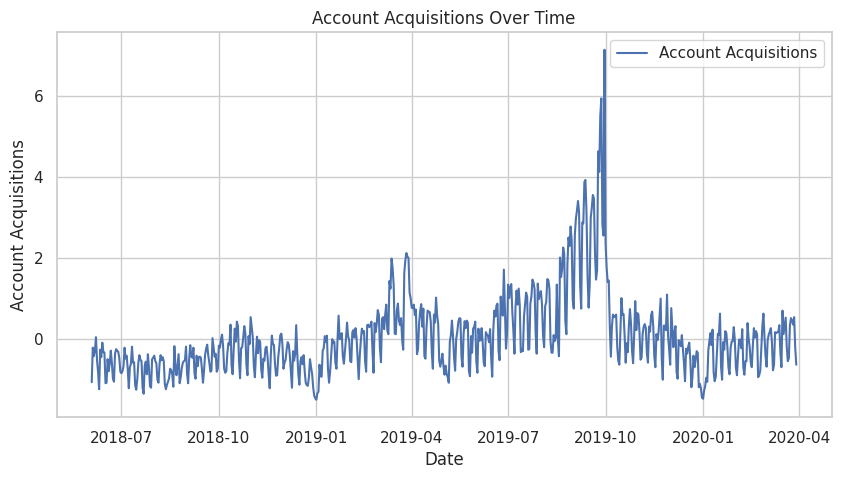

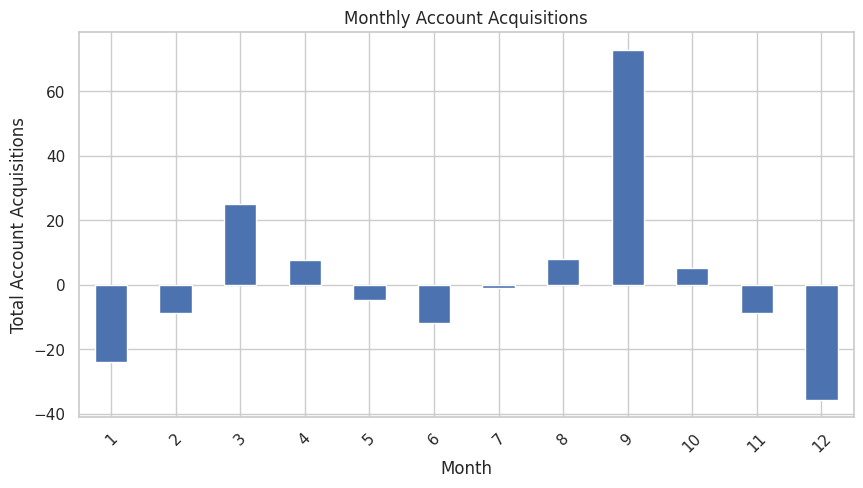

/tmp/ipython-input-2592693962.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([campaign_acquisitions, non_campaign_acquisitions], labels=['Campaign Days', 'Non-Campaign Days'])


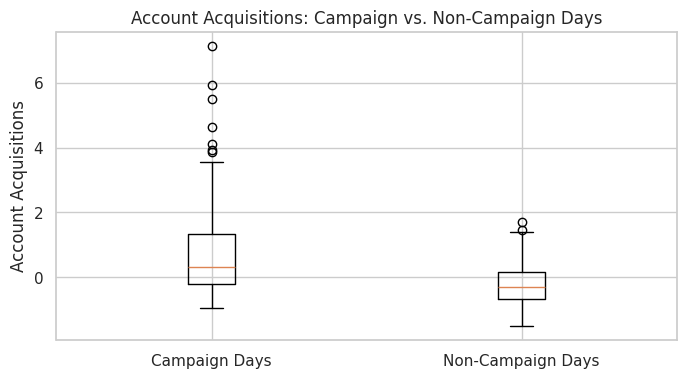

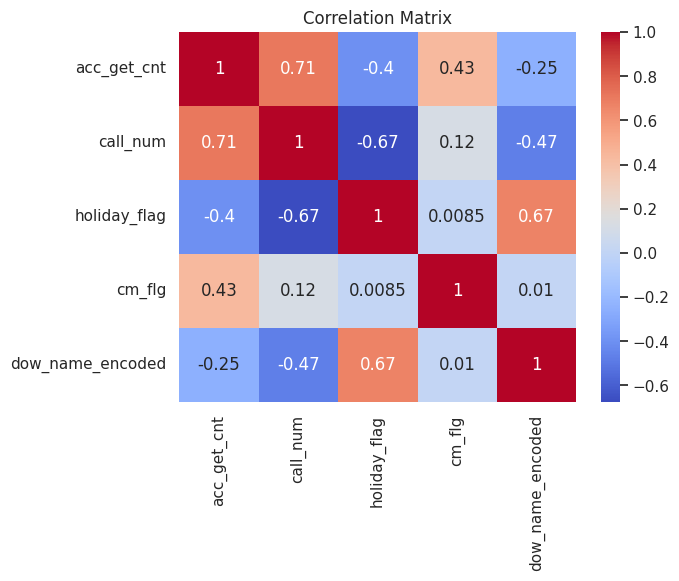

In [7]:


# ドライブのマウント
drive.mount('/content/drive')

# Seabornのスタイル設定
sns.set(style="whitegrid")

# ファイルパスとデータセット名
paths = [
    '/content/drive/MyDrive/GCI/GCI最終課題AirREGI/AirREGI/calender_data.csv',
    '/content/drive/MyDrive/GCI/GCI最終課題AirREGI/AirREGI/cm_data.csv',
    '/content/drive/MyDrive/GCI/GCI最終課題AirREGI/AirREGI/gt_service_name.csv',
    '/content/drive/MyDrive/GCI/GCI最終課題AirREGI/AirREGI/regi_acc_get_data_transform.csv',
    '/content/drive/MyDrive/GCI/GCI最終課題AirREGI/AirREGI/regi_call_data_transform.csv'
]
dataset_names = ['calendar_data', 'cm_data', 'gt_service_name', 'regi_acc_get_data_transform', 'regi_call_data_transform']

# データの読み込み
datasets = {name: pd.read_csv(path) for name, path in zip(dataset_names, paths)}

# 日付カラムの統一処理
for name, df in datasets.items():
    if 'cdr_date' in df.columns or 'week' in df.columns:
        date_col = 'cdr_date' if 'cdr_date' in df.columns else 'week'
        df.rename(columns={date_col: 'cdr_date'}, inplace=True)
        df['cdr_date'] = pd.to_datetime(df['cdr_date'])

# 欠損値の確認
for name, df in datasets.items():
    print(f"{name} - 欠損値の数:\n{df.isnull().sum()}\n")

# calendar_data の欠損値処理
calendar_data = datasets['calendar_data']
calendar_data['holiday_name'] = calendar_data['holiday_name'].fillna(
    calendar_data['holiday_flag'].map({True: 'Public Holiday', False: 'No Holiday'})
)
datasets['calendar_data'] = calendar_data  # 修正したデータを再格納

# カテゴリカルデータのエンコーディング（holiday_name）
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse を sparse_output に置き換える
holiday_name_onehot = onehot.fit_transform(calendar_data[['holiday_name']])
holiday_name_cols = onehot.get_feature_names_out(['holiday_name'])
holiday_name_df = pd.DataFrame(holiday_name_onehot, columns=holiday_name_cols, index=calendar_data.index)
calendar_data = pd.concat([calendar_data, holiday_name_df], axis=1)


# データセットの統合
data_frames = [calendar_data, datasets['cm_data'], datasets['gt_service_name'],
               datasets['regi_acc_get_data_transform'], datasets['regi_call_data_transform']]
merged_data = reduce(lambda left, right: pd.merge(left, right, on='cdr_date', how='outer'), data_frames)

for name, df in datasets.items():
    if 'cdr_date' in df.columns:
        print(f"{name} - Missing values in 'cdr_date': {df['cdr_date'].isna().sum()}")
    else:
        print(f"{name} - 'cdr_date' column is missing.")



# 統合後の欠損値処理
merged_data.fillna({
    'holiday_flag': 0,
    'cm_flg': 0,
    'call_num': 0,
    'acc_get_cnt': merged_data['acc_get_cnt'].median()
}, inplace=True)



# 日付フィルタリング
start_date = '2018-06-03'
end_date = '2020-03-29'
merged_data = merged_data[(merged_data['cdr_date'] >= start_date) & (merged_data['cdr_date'] <= end_date)]

print(f"Before filtering: {len(merged_data)} rows")
merged_data = merged_data[(merged_data['cdr_date'] >= start_date) & (merged_data['cdr_date'] <= end_date)]
print(f"After filtering: {len(merged_data)} rows")



# 曜日エンコード
dow_map = {'月': 0, '火': 1, '水': 2, '木': 3, '金': 4, '土': 5, '日': 6}
merged_data['dow_name_encoded'] = merged_data['dow_name'].replace(dow_map)

if 'dow_name' in merged_data.columns:
    print(f"Unique values in 'dow_name': {merged_data['dow_name'].unique()}")
else:
    print("Error: 'dow_name' column is missing.")


# acc_get_cnt の時系列プロット
plt.figure(figsize=(10, 5))
plt.plot(merged_data['cdr_date'], merged_data['acc_get_cnt'], label='Account Acquisitions')
plt.title('Account Acquisitions Over Time')
plt.xlabel('Date')
plt.ylabel('Account Acquisitions')
plt.legend()
plt.grid(True)
plt.show()


# 月別アカウント獲得数プロット
# 'month' 列を作成
merged_data['month'] = merged_data['cdr_date'].dt.month
monthly_acquisitions = merged_data.groupby('month')['acc_get_cnt'].sum()
plt.figure(figsize=(10, 5))
monthly_acquisitions.plot(kind='bar')
plt.title('Monthly Account Acquisitions')
plt.xlabel('Month')
plt.ylabel('Total Account Acquisitions')
plt.xticks(rotation=45)
plt.show()



# キャンペーン日 vs 非キャンペーン日のアカウント獲得数比較
campaign_acquisitions = merged_data[merged_data['cm_flg'] == 1]['acc_get_cnt']
non_campaign_acquisitions = merged_data[merged_data['cm_flg'] == 0]['acc_get_cnt']
plt.figure(figsize=(8, 4))
plt.boxplot([campaign_acquisitions, non_campaign_acquisitions], labels=['Campaign Days', 'Non-Campaign Days'])
plt.title('Account Acquisitions: Campaign vs. Non-Campaign Days')
plt.ylabel('Account Acquisitions')
plt.show()

# 特徴量と目的変数の相関分析
correlation = merged_data[['acc_get_cnt', 'call_num', 'holiday_flag', 'cm_flg', 'dow_name_encoded']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# データの保存
merged_data.to_csv('merged_data.csv', index=False)


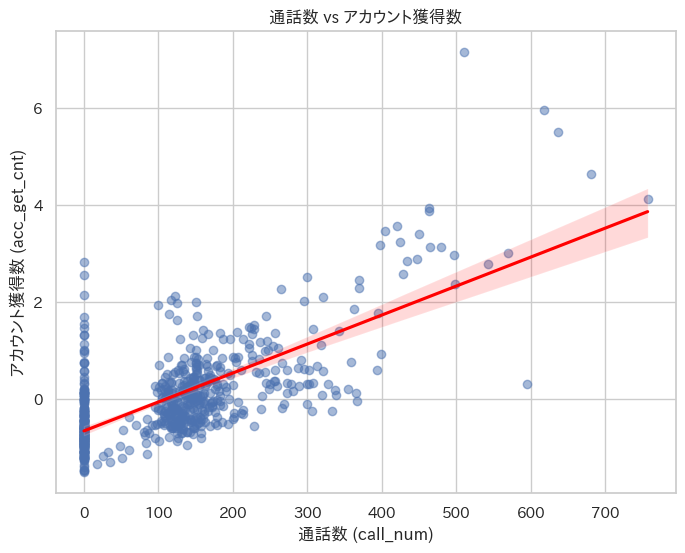

In [26]:

plt.figure(figsize=(8,6))
sns.regplot(x='call_num', y='acc_get_cnt', data=merged_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('通話数 vs アカウント獲得数')
plt.xlabel('通話数 (call_num)')
plt.ylabel('アカウント獲得数 (acc_get_cnt)')
plt.show()


acc_get_cnt と各変数の相関

１、通話数が増えるとアカウント獲得数も増える傾向。非常に重要な特徴量

２、holiday_flag（祝日フラグ）: -0.4

負の相関が見られ、祝日であるとアカウント獲得数が減少する傾向があります。
これはビジネス特性（祝日は企業活動が少ない）に基づく可能性が高い

３、cm_flg（CM放送フラグ）: 0.43

中程度の正の相関があります。
CM放送がアカウント獲得数に一定の影響を与える

call_num（通話数）と他の変数の相関

１、通話数は祝日には大きく減少する

２、cm_flg: 0.12

通話数に対するCM放送の影響は弱い

dow_name_encoded: -0.47

曜日による通話数の変動が中程度に観察されます。





** ビジネスインサイト**

通話数がアカウント獲得数に強い影響を与えている:

アカウント獲得数を増加させるには、通話数を増やす施策（例えば、特定の曜日や時間帯に効率的な営業活動を行う）が有効です。

祝日がネガティブに作用する:

祝日には営業活動が低下するため、別のアプローチ（オンラインキャンペーンなど）を検討する価値があります。

CM放送は中程度の効果がある:

CM放送が直接的にアカウント獲得数を増加させる可能性がありますが、その効果を最大化するには、祝日や特定の曜日との組み合わせを検討する必要があります。

In [9]:
print("Preview of merged_data:")
print(merged_data.head())
print("Columns in merged_data:", merged_data.columns.tolist())


Preview of merged_data:
     cdr_date  dow dow_name   woy  wom    doy  financial_year  \
94 2018-06-03  7.0        日  22.0  2.0  154.0          2018.0   
95 2018-06-04  1.0        月  23.0  2.0  155.0          2018.0   
96 2018-06-05  2.0        火  23.0  2.0  156.0          2018.0   
97 2018-06-06  3.0        水  23.0  2.0  157.0          2018.0   
98 2018-06-07  4.0        木  23.0  2.0  158.0          2018.0   

   day_before_holiday_flag holiday_flag    holiday_name  ...  \
94                   False         True  Public Holiday  ...   
95                   False        False      No Holiday  ...   
96                   False        False      No Holiday  ...   
97                   False        False      No Holiday  ...   
98                   False        False      No Holiday  ...   

    holiday_name_春分の日  holiday_name_昭和の日  holiday_name_海の日  holiday_name_秋分の日  \
94                0.0                0.0               0.0                0.0   
95                0.0                0

曜日ごと通話数の比較:

In [10]:
print("Preview of merged_data:")
print(merged_data.head())

print("Unique values in dow_name:")
print(merged_data['dow_name'].unique())

print("Unique values in cm_flg:")
print(merged_data['cm_flg'].unique())


Preview of merged_data:
     cdr_date  dow dow_name   woy  wom    doy  financial_year  \
94 2018-06-03  7.0        日  22.0  2.0  154.0          2018.0   
95 2018-06-04  1.0        月  23.0  2.0  155.0          2018.0   
96 2018-06-05  2.0        火  23.0  2.0  156.0          2018.0   
97 2018-06-06  3.0        水  23.0  2.0  157.0          2018.0   
98 2018-06-07  4.0        木  23.0  2.0  158.0          2018.0   

   day_before_holiday_flag holiday_flag    holiday_name  ...  \
94                   False         True  Public Holiday  ...   
95                   False        False      No Holiday  ...   
96                   False        False      No Holiday  ...   
97                   False        False      No Holiday  ...   
98                   False        False      No Holiday  ...   

    holiday_name_春分の日  holiday_name_昭和の日  holiday_name_海の日  holiday_name_秋分の日  \
94                0.0                0.0               0.0                0.0   
95                0.0                0

In [11]:
# 曜日名を生成
merged_data['dow_name'] = merged_data['cdr_date'].dt.day_name()

# 曜日の順序を指定
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# 曜日をカテゴリ型に設定
merged_data['dow_name'] = pd.Categorical(merged_data['dow_name'], categories=weekday_order, ordered=True)

# `cm_flg` の欠損値を確認し、処理する
if merged_data['cm_flg'].isnull().sum() > 0:
    merged_data['cm_flg'].fillna(0, inplace=True)  # 必要なら補完

# データが空でないか確認
if merged_data.empty:
    print("Error: Merged data is empty after preprocessing.")
else:
    print(f"Merged data contains {len(merged_data)} rows.")

# `call_num` の欠損値を確認
if merged_data['call_num'].isnull().sum() > 0:
    merged_data['call_num'].fillna(0, inplace=True)  # 必要なら補完


Merged data contains 666 rows.


/tmp/ipython-input-3860205411.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].mean().unstack()


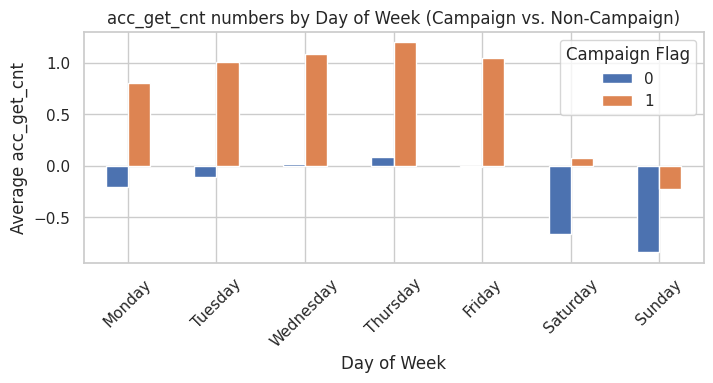

In [12]:
# 目的: 曜日（dow_name）とキャンペーンフラグ（cm_flg）の組み合わせが、アカウント獲得数に与える影響を分析

# 曜日の順序を指定
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# 曜日をカテゴリ型に設定
merged_data['dow_name'] = pd.Categorical(merged_data['dow_name'], categories=weekday_order, ordered=True)

# グループ化とプロット
weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].mean().unstack()
weekday_comparison.plot(kind='bar', figsize=(8, 3))
plt.title('acc_get_cnt numbers by Day of Week (Campaign vs. Non-Campaign)')
plt.xlabel('Day of Week')
plt.ylabel('Average acc_get_cnt')
plt.xticks(rotation=45)
plt.legend(title='Campaign Flag')
plt.show()


「どの曜日・条件下でキャンペーンが成功しているか？」

火曜、水曜、木曜が顕著。　土日はキャンペーンがほぼ行われていないのでは。
水金はキャンペーンが必ず行われていたのでは。

In [13]:
# 仮説の検証：曜日ごとにキャンペーンフラグの有無を集計
campaign_counts = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].count().unstack()
print(campaign_counts)


/tmp/ipython-input-2159163663.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  campaign_counts = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].count().unstack()


cm_flg      0   1
dow_name         
Monday     67  28
Tuesday    68  27
Wednesday  68  27
Thursday   67  28
Friday     65  30
Saturday   66  29
Sunday     68  28


キャンペーンなし　０　　キャンペーンあり　１

土日にキャンペーンありがそれぞれ、２９、２８あるので、キャンペーンは行われていた。

水金でもキャンペーンなしの日もあった。68, 65

むしろ、水曜・金曜のキャンペーン実施率は他の平日と同じ程度

**🌻平日と比較して、土日でのキャンペーン効果は小さいため、今後の施策として、土日のリソース配分や代替施策（例: オンラインマーケティング）の検討が必要です。**

In [14]:
# print(merged_data.columns)  # 必要な列が存在するか確認
# print(merged_data[['dow_name', 'cm_flg', 'call_num']].head())  # サンプルデータ確認


In [15]:
# print(merged_data['dow_name'].unique())  # 曜日のユニーク値を確認


In [16]:
# print(merged_data['call_num'].dtype)  # データ型を確認


In [17]:
# print(weekday_comparison)  # グループ化結果を確認


In [18]:
# import matplotlib
# print(matplotlib.get_backend())  # 使用中のバックエンドを確認


/tmp/ipython-input-1054107740.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['call_num'].mean().unstack()


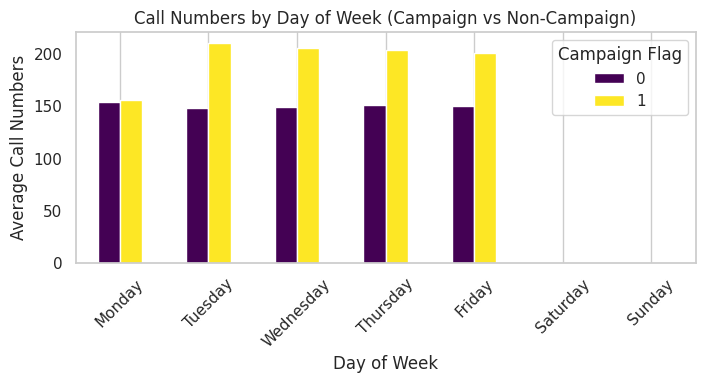

In [19]:
# グループ化と集計
weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['call_num'].mean().unstack()

# データが空でないか確認
if weekday_comparison.empty:
    print("Grouped data is empty. Please check dow_name or cm_flg values.")
else:
    # プロット
    weekday_comparison.plot(kind='bar', figsize=(8, 3), colormap='viridis')
    plt.title('Call Numbers by Day of Week (Campaign vs Non-Campaign)')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Call Numbers')
    plt.xticks(rotation=45)
    plt.legend(title='Campaign Flag')
    plt.grid(axis='y')
    plt.show()


/tmp/ipython-input-2357516400.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['call_num'].mean().unstack()


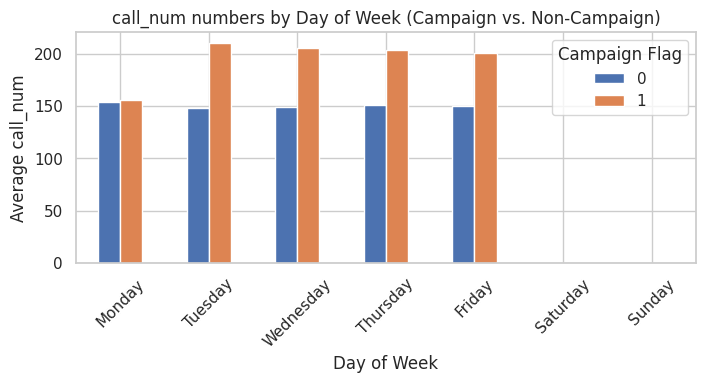

In [20]:
# 目的: 曜日（dow_name）とキャンペーンフラグ（cm_flg）の組み合わせが、通話数に与える影響を分析
plt.show()

# 曜日の順序を指定
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# 曜日をカテゴリ型に設定
merged_data['dow_name'] = pd.Categorical(merged_data['dow_name'], categories=weekday_order, ordered=True)

# グループ化とプロット
weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['call_num'].mean().unstack()
weekday_comparison.plot(kind='bar', figsize=(8, 3))
plt.title('call_num numbers by Day of Week (Campaign vs. Non-Campaign)')
plt.xlabel('Day of Week')
plt.ylabel('Average call_num')
plt.xticks(rotation=45)
plt.legend(title='Campaign Flag')
plt.show()



通話数が多い曜日がキャンペーン成功の指標になるか？

In [21]:
# 曜日ごとのキャンペーン効果を再分析
weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].mean().unstack()
print(weekday_comparison)


/tmp/ipython-input-3069160725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].mean().unstack()


cm_flg            0         1
dow_name                     
Monday    -0.209270  0.804085
Tuesday   -0.108177  1.006709
Wednesday  0.013847  1.082850
Thursday   0.089437  1.197292
Friday    -0.006764  1.042073
Saturday  -0.656813  0.075643
Sunday    -0.839953 -0.229576


平日（月曜～金曜）の傾向
キャンペーンあり（cm_flg = 1）:

平日（月曜～金曜）のキャンペーンありの平均値はすべて正の値であり、特に火曜（1.007）、水曜（1.083）、**木曜（1.197）**が高いです。
これは、平日のキャンペーンがアカウント獲得数に効果的であることを示しています。
キャンペーンなし（cm_flg = 0）:

キャンペーンなしの場合、平日の平均値は全体的に小さく、ほぼ0付近の値（例: 水曜0.014、金曜-0.007）になっています。
キャンペーンなしでは、アカウント獲得がほとんど発生していないことを示唆します

土日の傾向
キャンペーンあり（cm_flg = 1）:

土曜日（0.076）や日曜日（-0.230）では、キャンペーンありでもアカウント獲得数が極めて低い、または負の値になっています。
これは、土日のキャンペーンがほとんど効果を発揮していないことを示しています。
キャンペーンなし（cm_flg = 0）:

土曜（-0.657）、日曜（-0.840）で、キャンペーンなしの場合にはさらにアカウント獲得数が低い傾向があります。
土日では営業活動やアカウント獲得がほぼ停止している可能性が考えられます。



平日 vs 土日のキャンペーン効果
平日（特に火曜～木曜）ではキャンペーンの効果が明らかに高く、アカウント獲得数が1.0以上に達しています。
土日ではキャンペーンがほとんど効果を発揮しておらず、アカウント獲得数の平均が0付近、または負の値です。
4. 解釈のポイント
平日のキャンペーンの成功:

火曜～木曜が特にキャンペーン効果の高い曜日であるため、これらの曜日にキャンペーンを集中させると、アカウント獲得数の効率的な増加が期待できます。
土日のキャンペーンの非効率性:

土日ではキャンペーン効果がほとんどなく、リソース配分が非効率である可能性が高いです。
これは、営業活動が活発でないためか、ターゲットユーザーの行動パターンに合っていないためと考えられます。
キャンペーンなしの影響:

平日でもキャンペーンなしの場合、アカウント獲得がほとんど発生しないため、キャンペーンの有無が重要なドライバーであることがわかります。


**次のアクション**
**キャンペーン戦略の最適化:**

平日（特に火曜～木曜）にキャンペーンを集中的に実施する。
土日ではリソースを別の施策（オンライン対応、広告など）に切り替えることを検討する。
キャンペーンの内容を見直し:

土日でキャンペーンを続ける場合、ターゲット層に応じた施策（例: オンラインキャンペーンやソーシャルメディア広告）を強化。
データ補完と仮説検証:

他の要因（例: 時間帯、季節性など）がキャンペーンの効果にどのように影響しているかを分析する。

cm_flg         0         1
month                     
1      -0.468161 -0.116346
2      -0.237701 -0.078721
3       0.280841  0.447289
4       0.251531       NaN
5      -0.298907 -0.001112
6      -0.205997       NaN
7      -0.017185       NaN
8      -0.737282  0.998941
9      -0.536898  1.909399
10     -0.057410  0.575415
11     -0.144565       NaN
12     -0.574286       NaN


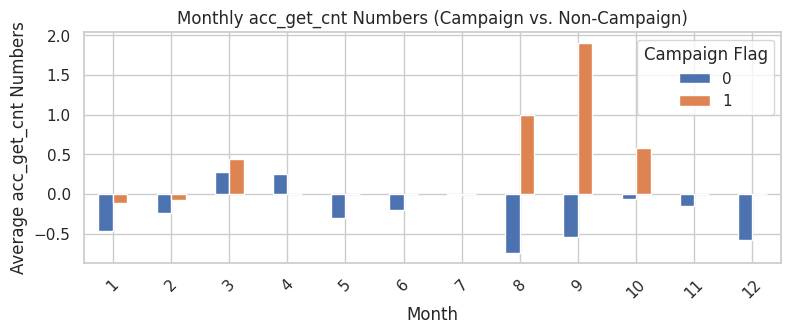

In [22]:
monthly_comparison = merged_data.groupby(['month', 'cm_flg'])['acc_get_cnt'].mean().unstack()
print(monthly_comparison)
monthly_comparison.plot(kind='bar', figsize=(9, 3))
plt.title('Monthly acc_get_cnt Numbers (Campaign vs. Non-Campaign)')
plt.xlabel('Month')
plt.ylabel('Average acc_get_cnt Numbers')
plt.xticks(rotation=45)
plt.legend(title='Campaign Flag')
plt.show()

🌻キャンペーンの大きな効果:

キャンペーンがアカウント獲得にとって非常に重要であることが明白です。
特に9月のキャンペーンは、非常に高い効果を発揮しているため、重点的に分析する価値があります。

季節的な変動:

6月～7月はアカウント獲得数が低迷しているため、この時期の営業効率を改善するか、特別な施策を検討する必要があります

_name____lp月ごとの通話数の比較:

cm_flg           0           1
month                         
1        67.937500    0.000000
2        85.777778   86.833333
3        91.500000   83.960000
4       114.166667         NaN
5        90.125000  113.466667
6        98.413793         NaN
7       122.693548         NaN
8        80.516129  173.741935
9        66.470588  245.372093
10      148.958333  202.857143
11      123.050000         NaN
12      121.161290         NaN


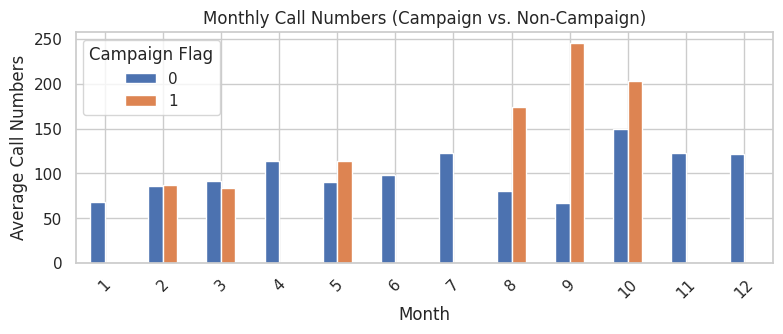

In [23]:
monthly_comparison = merged_data.groupby(['month', 'cm_flg'])['call_num'].mean().unstack()
print(monthly_comparison)
monthly_comparison.plot(kind='bar', figsize=(9, 3))
plt.title('Monthly Call Numbers (Campaign vs. Non-Campaign)')
plt.xlabel('Month')
plt.ylabel('Average Call Numbers')
plt.xticks(rotation=45)
plt.legend(title='Campaign Flag')
plt.show()


🌻通話数がアカウント獲得に寄与:

通話数が多い月はアカウント獲得数も高くなる傾向が見られるため、通話数を増やすことが成功の鍵となります。

特に9月や10月のキャンペーンでは、通話数とアカウント獲得数が一致して増加しているため、強化すべきタイミング。

🌻 通話数が少ない期間（6月～7月）はアカウント獲得数も低迷しているため、この時期の通話

In [24]:
# search_cntの欠損値数
print(merged_data['search_cnt'].isna().sum())

# 欠損値処理

from sklearn.linear_model import LinearRegression

# 完全データ（欠損値のない行）の抽出
complete_data = merged_data.dropna(subset=['search_cnt', 'call_num'])

# 特徴量と目的変数を設定
X = complete_data[['call_num']]  # 他に使えそうな特徴量があれば追加可能
y = complete_data['search_cnt']

# 線形回帰モデルのトレーニング
model = LinearRegression().fit(X, y)

# 欠損値を補完
merged_data['search_cnt'] = merged_data.apply(
    lambda row: model.predict([[row['call_num']]])[0] if pd.isna(row['search_cnt']) else row['search_cnt'],
    axis=1
)

# 補完結果の確認
print(merged_data['search_cnt'].isna().sum())  # 結果は0となるはず


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

570


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

0


検索トレンドとキャンペーンフラグの関係:

cm_flg
0    36.321406
1    37.171690
Name: search_cnt, dtype: float64


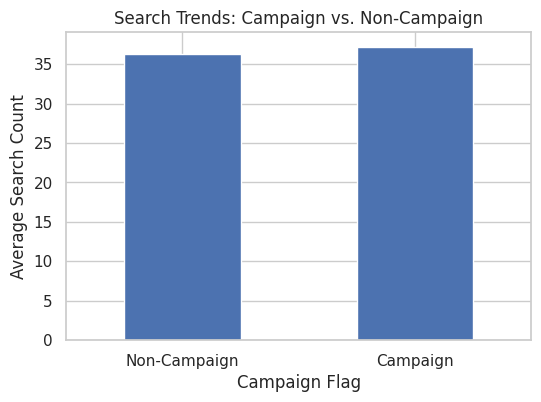

In [25]:
trend_campaign_comparison = merged_data.groupby('cm_flg')['search_cnt'].mean()
print(trend_campaign_comparison)
trend_campaign_comparison.plot(kind='bar', figsize=(6, 4))
plt.title('Search Trends: Campaign vs. Non-Campaign')
plt.xlabel('Campaign Flag')
plt.ylabel('Average Search Count')
plt.xticks([0, 1], ['Non-Campaign', 'Campaign'], rotation=0)
plt.show()


キャンペーンなし（cm_flg=0）の平均検索数：34.84

キャンペーンあり（cm_flg=1）の平均検索数：40.79

        search_cnt    call_num
cm_flg                        
0        36.321406  107.345416
1        37.171690  138.487310


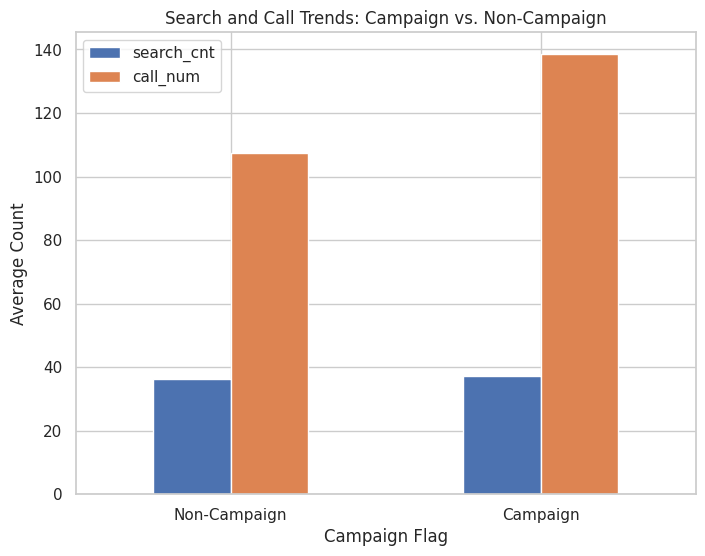

In [26]:
comparison = merged_data.groupby('cm_flg')[['search_cnt', 'call_num']].mean()
print(comparison)

comparison.plot(kind='bar', figsize=(8, 6))
plt.title('Search and Call Trends: Campaign vs. Non-Campaign')
plt.xlabel('Campaign Flag')
plt.ylabel('Average Count')
plt.xticks([0, 1], ['Non-Campaign', 'Campaign'], rotation=0)
plt.show()


4. 時間的トレンドの分析
週単位・月単位のトレンドを可視化
データを週または月単位に集約して、通話数の変化を確認します。

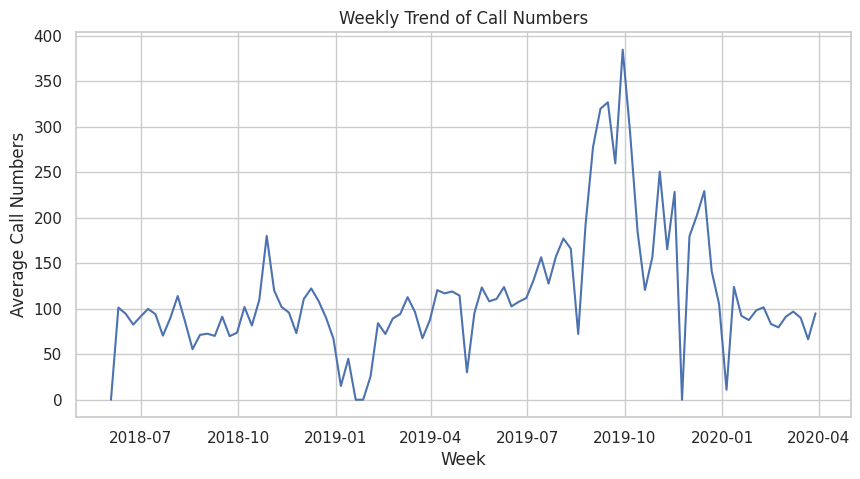

In [27]:
weekly_trend = merged_data.groupby('cdr_date')['call_num'].sum().resample('W').mean()
plt.figure(figsize=(10, 5))
plt.plot(weekly_trend)
plt.title('Weekly Trend of Call Numbers')
plt.xlabel('Week')
plt.ylabel('Average Call Numbers')
plt.grid(True)
plt.show()


異常値の詳細分析
通話数の外れ値を調査
異常に高い通話数の日を特定して、その日付や関連する要因（キャンペーンや休日）を調べます:

In [28]:
high_calls = merged_data[merged_data['call_num'] > merged_data['call_num'].quantile(0.95)]
print("High Call Days Analysis:")
print(high_calls[['cdr_date', 'call_num', 'cm_flg', 'holiday_flag', 'holiday_name']])


High Call Days Analysis:
      cdr_date  call_num  cm_flg holiday_flag holiday_name
238 2018-10-25     595.0       0        False   No Holiday
543 2019-08-26     363.0       1        False   No Holiday
545 2019-08-28     369.0       1        False   No Holiday
546 2019-08-29     543.0       1        False   No Holiday
547 2019-08-30     369.0       1        False   No Holiday
550 2019-09-02     428.0       1        False   No Holiday
551 2019-09-03     497.0       1        False   No Holiday
552 2019-09-04     398.0       1        False   No Holiday
553 2019-09-05     450.0       1        False   No Holiday
554 2019-09-06     465.0       1        False   No Holiday
557 2019-09-09     447.0       1        False   No Holiday
558 2019-09-10     434.0       1        False   No Holiday
559 2019-09-11     463.0       1        False   No Holiday
560 2019-09-12     464.0       1        False   No Holiday
561 2019-09-13     480.0       1        False   No Holiday
565 2019-09-17     569.0       

次のステップ

6. 予測モデル構築の準備
データのスケーリングと特徴エンジニアリング
機械学習モデル用にデータを準備（特徴量のスケーリングや重要な特徴量の作成）。
回帰モデルの構築
通話数を予測するモデルを構築し、キャンペーンの効果を数値的に評価。

In [29]:
#####################

**アカウント獲得数（acc_get_cnt）に対するEDA**

データのプレビュー:
     cdr_date  dow   dow_name   woy  wom    doy  financial_year  \
94 2018-06-03  7.0     Sunday  22.0  2.0  154.0          2018.0   
95 2018-06-04  1.0     Monday  23.0  2.0  155.0          2018.0   
96 2018-06-05  2.0    Tuesday  23.0  2.0  156.0          2018.0   
97 2018-06-06  3.0  Wednesday  23.0  2.0  157.0          2018.0   
98 2018-06-07  4.0   Thursday  23.0  2.0  158.0          2018.0   

   day_before_holiday_flag holiday_flag    holiday_name  ...  \
94                   False         True  Public Holiday  ...   
95                   False        False      No Holiday  ...   
96                   False        False      No Holiday  ...   
97                   False        False      No Holiday  ...   
98                   False        False      No Holiday  ...   

    holiday_name_春分の日  holiday_name_昭和の日  holiday_name_海の日  holiday_name_秋分の日  \
94                0.0                0.0               0.0                0.0   
95                0.0                0.

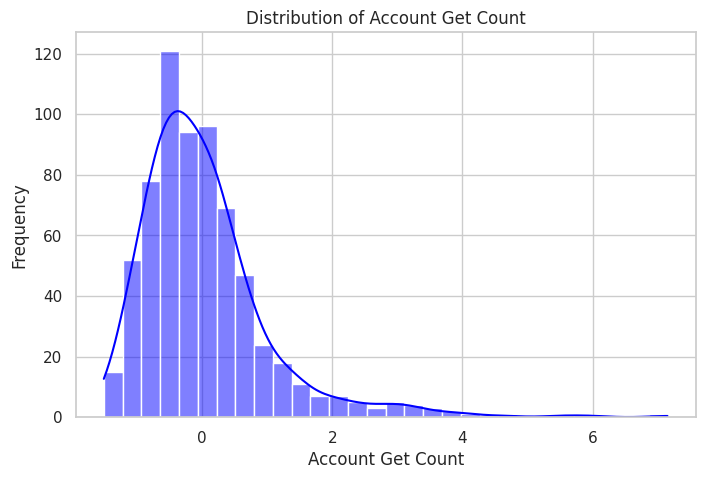


曜日別アカウント獲得数の比較（CM放送有無）:
cm_flg            0         1
dow_name                     
Friday    -0.006764  1.042073
Monday    -0.209270  0.804085
Saturday  -0.656813  0.075643
Sunday    -0.839953 -0.229576
Thursday   0.089437  1.197292
Tuesday   -0.108177  1.006709
Wednesday  0.013847  1.082850


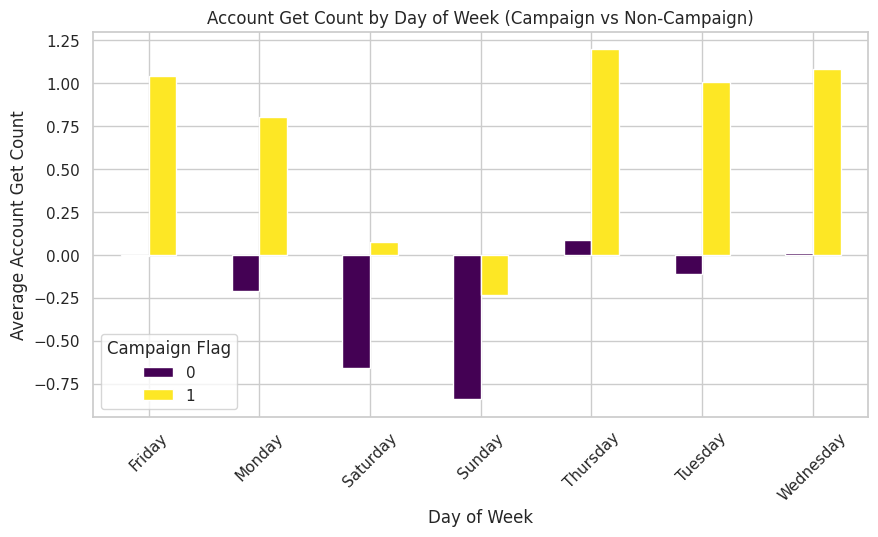

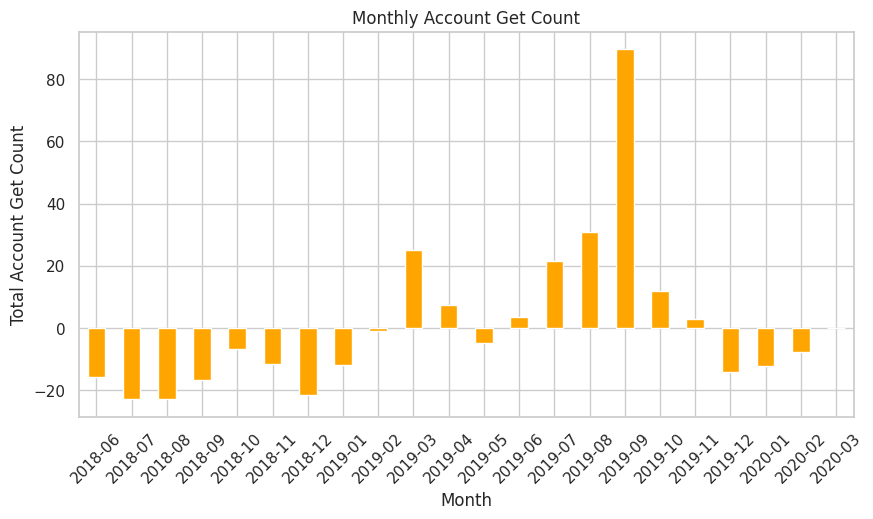


キャンペーン有無によるアカウント獲得数の比較:
キャンペーンあり: 0.7080426327850847
キャンペーンなし: -0.245947619188324


/tmp/ipython-input-3559195486.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


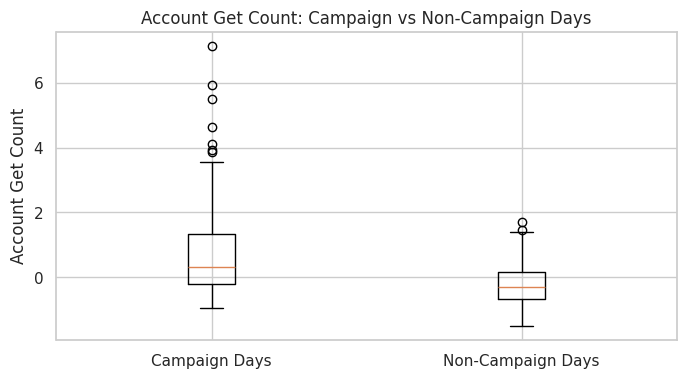


祝日別アカウント獲得数:
holiday_flag
False    0.321499
True    -0.546006
Name: acc_get_cnt, dtype: float64


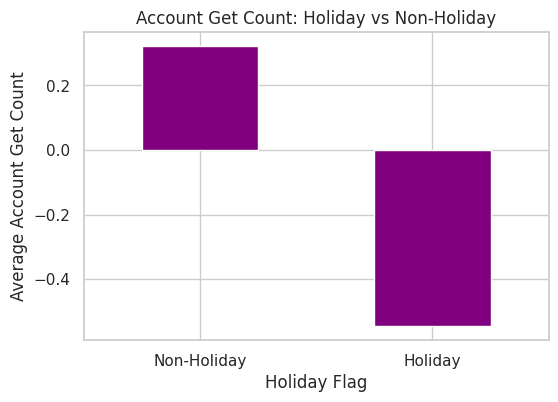


特定の休日別アカウント獲得数:
holiday_name
元日                   -1.496330
天皇誕生日                -1.025720
こどもの日                -0.951414
成人の日                 -0.877107
みどりの日                -0.864722
休日                   -0.737781
山の日                  -0.734685
体育の日                 -0.722301
休日 (天皇の即位の日)         -0.678955
憲法記念日                -0.666571
海の日                  -0.654186
文化の日                 -0.592264
勤労感謝の日               -0.555110
昭和の日                 -0.542726
Public Holiday       -0.535268
建国記念の日               -0.486996
休日 (即位礼正殿の儀の行われる日)   -0.332190
春分の日                  0.070305
敬老の日                  0.262265
秋分の日                  0.435647
Name: acc_get_cnt, dtype: float64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30343 (\N{CJK UNIFIED IDEOGRAPH-7687}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35477 (\N{CJK UNIFIED IDEOGRAPH-8A95}) missing from font(s) DejaVu Sans.
  fig.canvas

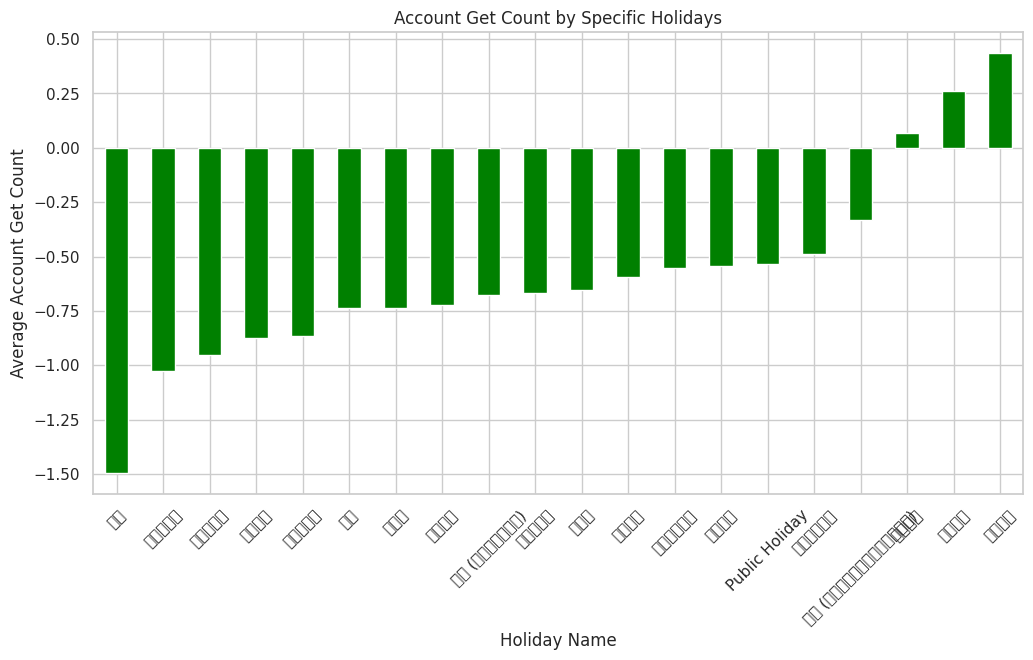

In [30]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seabornのスタイル設定
sns.set(style="whitegrid")

# データの統合後の確認
print("データのプレビュー:")
print(merged_data.head())

# 欠損値の確認
print("\n欠損値の確認:")
print(merged_data.isnull().sum())

# 日付フィルタリング
start_date = '2018-06-03'
end_date = '2020-03-29'
merged_data = merged_data[(merged_data['cdr_date'] >= start_date) & (merged_data['cdr_date'] <= end_date)]

print(f"\nデータフィルタリング後の行数: {len(merged_data)}")

# アカウント獲得数（acc_get_cnt）の基本統計量
print("\nアカウント獲得数（acc_get_cnt）の基本統計量:")
print(merged_data['acc_get_cnt'].describe())

# アカウント獲得数の分布を可視化
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['acc_get_cnt'], bins=30, kde=True, color='blue')
plt.title('Distribution of Account Get Count')
plt.xlabel('Account Get Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 曜日ごとのアカウント獲得数
merged_data['dow_name'] = merged_data['cdr_date'].dt.day_name()
weekday_comparison = merged_data.groupby(['dow_name', 'cm_flg'])['acc_get_cnt'].mean().unstack()

print("\n曜日別アカウント獲得数の比較（CM放送有無）:")
print(weekday_comparison)

weekday_comparison.plot(kind='bar', figsize=(10, 5), colormap='viridis')
plt.title('Account Get Count by Day of Week (Campaign vs Non-Campaign)')
plt.xlabel('Day of Week')
plt.ylabel('Average Account Get Count')
plt.xticks(rotation=45)
plt.legend(title='Campaign Flag')
plt.grid(True)
plt.show()

# 月別アカウント獲得数
merged_data['month'] = merged_data['cdr_date'].dt.to_period('M')
monthly_acc = merged_data.groupby('month')['acc_get_cnt'].sum()

plt.figure(figsize=(10, 5))
monthly_acc.plot(kind='bar', color='orange')
plt.title('Monthly Account Get Count')
plt.xlabel('Month')
plt.ylabel('Total Account Get Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# キャンペーン効果の分析
campaign_data = merged_data[merged_data['cm_flg'] == 1]
non_campaign_data = merged_data[merged_data['cm_flg'] == 0]

print("\nキャンペーン有無によるアカウント獲得数の比較:")
print("キャンペーンあり:", campaign_data['acc_get_cnt'].mean())
print("キャンペーンなし:", non_campaign_data['acc_get_cnt'].mean())

# キャンペーン効果の可視化
plt.figure(figsize=(8, 4))
plt.boxplot(
    [campaign_data['acc_get_cnt'], non_campaign_data['acc_get_cnt']],
    labels=['Campaign Days', 'Non-Campaign Days']
)
plt.title('Account Get Count: Campaign vs Non-Campaign Days')
plt.ylabel('Account Get Count')
plt.grid(True)
plt.show()

# 祝日とアカウント獲得数の比較
holiday_comparison = merged_data.groupby('holiday_flag')['acc_get_cnt'].mean()

print("\n祝日別アカウント獲得数:")
print(holiday_comparison)

holiday_comparison.plot(kind='bar', figsize=(6, 4), color='purple')
plt.title('Account Get Count: Holiday vs Non-Holiday')
plt.xlabel('Holiday Flag')
plt.ylabel('Average Account Get Count')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.grid(True)
plt.show()

# 特定の休日の分析
specific_holidays = merged_data[merged_data['holiday_name'] != 'No Holiday']
specific_holiday_comparison = specific_holidays.groupby('holiday_name')['acc_get_cnt'].mean().sort_values()

print("\n特定の休日別アカウント獲得数:")
print(specific_holiday_comparison)

specific_holiday_comparison.plot(kind='bar', figsize=(12, 6), color='green')
plt.title('Account Get Count by Specific Holidays')
plt.xlabel('Holiday Name')
plt.ylabel('Average Account Get Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [31]:
#####################

**特徴エンジニアリング**(新たな特徴量を生成する)

In [32]:
# # 週末と平日の違いを捉える。
merged_data['is_weekend'] = merged_data['dow'].isin([5, 6]).astype(int)


In [33]:
# 目的: 夏季（6月～8月）の特性を捉える。理由: 夏はキャンペーンや消費活動が増加することが多く、通話数に影響を与える可能性があるため。
merged_data['is_summer'] = merged_data['month'].isin([6, 7, 8]).astype(int)
#  目的: 年末（12月）の特性を捉える。理由: 年末は消費活動が活発になる時期であり、通話数に影響を与える可能性があるため。
merged_data['is_year_end'] = merged_data['month'].isin([12]).astype(int)


In [34]:
# キャンペーンと休日の組み合わせが通話数に与える影響を捉える。理由: キャンペーンが行われている休日は特定の行動パターンを引き起こす可能性が高い。

merged_data['holiday_campaign'] = (merged_data['cm_flg'] == 1) & (merged_data['holiday_flag'] == True)


In [35]:
"""call_num_7d_avg は、各行（各日付）に対して、
その日を含む過去7日間の問い合わせ件数の平均値を計算したものです。
これは 移動平均（Rolling Average）
と呼ばれる手法で、時間的な変動を滑らかにするためによく使われます。

計算の具体例
例えば、データが日単位で構成されている場合：

2023-01-08 の call_num_7d_avg は 2023-01-02 ～ 2023-01-08 の問い合わせ件数の平均。
2023-01-09 の call_num_7d_avg は 2023-01-03 ～ 2023-01-09 の問い合わせ件数の平均。
これが Pandas の rolling(window=7).mean() 関数で計算されています。"""
# 過去7日間の移動平均を計算し、短期的なトレンドを捉える。理由: 時系列データでは直近の動向が重要な予測要因となるため、短期トレンドを明示することが有益。

merged_data['call_num_7d_avg'] = merged_data['call_num'].rolling(window=7).mean()


In [36]:
# 過去データを使って計算
# 初めてcall_num_7d_avg、call_num_diffを定義
merged_data['call_num_7d_avg'] = merged_data['call_num'].shift(1).rolling(window=7).mean()
merged_data['call_num_diff'] = merged_data['call_num'].shift(1).diff()


⚠️
call_num_7d_avg：rolling(window=7) により、最初の7行（データが不足する範囲）が欠損値になる

call_num_diff:　shift(1) により、最初の1行が欠損値になる

In [37]:
merged_data['call_num_7d_avg'].fillna(method='ffill', inplace=True)
merged_data['call_num_diff'].fillna(method='ffill', inplace=True)


/tmp/ipython-input-1881135284.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['call_num_7d_avg'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-1881135284.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['call_num_7d_avg'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-1881135284.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment us

In [38]:
# call_num_7d_avg の欠損値処理
merged_data['call_num_7d_avg'] = merged_data['call_num_7d_avg'].fillna(merged_data['call_num_7d_avg'].mean())
merged_data['call_num_7d_avg'] = merged_data['call_num_7d_avg'].ffill()

# call_num_diff の欠損値処理

merged_data['call_num_diff'] = merged_data['call_num_diff'].fillna(0)

# 欠損値確認
print("欠損値の確認:")
print(merged_data[['call_num_7d_avg', 'call_num_diff']].isnull().sum())


欠損値の確認:
call_num_7d_avg    0
call_num_diff      0
dtype: int64


In [39]:
# # call_num_diff の残った欠損値を 0 で埋める
# merged_data['call_num_diff'] = merged_data['call_num_diff'].fillna(0)

# # 確認
# print("欠損値の確認（最終確認）:")
# print(merged_data[['call_num_7d_avg', 'call_num_diff']].isnull().sum())


In [40]:
# dow と is_weekend の関係を確認
weekend_check = merged_data[['dow', 'is_weekend']].value_counts()
print("dow と is_weekend の分布:")
print(weekend_check)

# dow=7 (日曜) や dow=6 (土曜) で is_weekend=0 のデータを確認
invalid_weekend = merged_data[(merged_data['dow'].isin([6.0, 7.0])) & (merged_data['is_weekend'] == 0)]
print("\n不正な is_weekend 値を持つデータ:")
print(invalid_weekend)


dow と is_weekend の分布:
dow  is_weekend
7.0  0             96
2.0  0             95
1.0  0             95
3.0  0             95
4.0  0             95
5.0  1             95
6.0  1             95
Name: count, dtype: int64

不正な is_weekend 値を持つデータ:
      cdr_date  dow dow_name   woy  wom    doy  financial_year  \
94  2018-06-03  7.0   Sunday  22.0  2.0  154.0          2018.0   
101 2018-06-10  7.0   Sunday  23.0  3.0  161.0          2018.0   
108 2018-06-17  7.0   Sunday  24.0  4.0  168.0          2018.0   
115 2018-06-24  7.0   Sunday  25.0  5.0  175.0          2018.0   
122 2018-07-01  7.0   Sunday  26.0  1.0  182.0          2018.0   
..         ...  ...      ...   ...  ...    ...             ...   
731 2020-03-01  7.0   Sunday   9.0  1.0   61.0          2019.0   
738 2020-03-08  7.0   Sunday  10.0  2.0   68.0          2019.0   
745 2020-03-15  7.0   Sunday  11.0  3.0   75.0          2019.0   
752 2020-03-22  7.0   Sunday  12.0  4.0   82.0          2019.0   
759 2020-03-29  7.0   Sunday  1

In [41]:
# dow の値に基づいて is_weekend を再計算
merged_data['is_weekend'] = merged_data['dow'].apply(lambda x: 1 if x in [6.0, 7.0] else 0)

# 再計算後の分布確認
print("修正後の dow と is_weekend の分布:")
print(merged_data[['dow', 'is_weekend']].value_counts())


修正後の dow と is_weekend の分布:
dow  is_weekend
7.0  1             96
2.0  0             95
1.0  0             95
3.0  0             95
4.0  0             95
5.0  0             95
6.0  1             95
Name: count, dtype: int64


In [42]:
# 不正な is_weekend 値を再確認
invalid_weekend = merged_data[(merged_data['dow'].isin([6.0, 7.0])) & (merged_data['is_weekend'] == 0)]
print("\n修正後も不正なデータが残っている場合:")
print(invalid_weekend)



修正後も不正なデータが残っている場合:
Empty DataFrame
Columns: [cdr_date, dow, dow_name, woy, wom, doy, financial_year, day_before_holiday_flag, holiday_flag, holiday_name, holiday_name_No Holiday, holiday_name_Public Holiday, holiday_name_こどもの日, holiday_name_みどりの日, holiday_name_休日, holiday_name_休日 (即位礼正殿の儀の行われる日), holiday_name_休日 (天皇の即位の日), holiday_name_体育の日, holiday_name_元日, holiday_name_勤労感謝の日, holiday_name_天皇誕生日, holiday_name_山の日, holiday_name_建国記念の日, holiday_name_憲法記念日, holiday_name_成人の日, holiday_name_敬老の日, holiday_name_文化の日, holiday_name_春分の日, holiday_name_昭和の日, holiday_name_海の日, holiday_name_秋分の日, cm_flg, search_cnt, acc_get_cnt, call_num, dow_name_encoded, month, is_weekend, is_summer, is_year_end, holiday_campaign, call_num_7d_avg, call_num_diff]
Index: []

[0 rows x 43 columns]


In [43]:
# 夏季フラグの再確認
summer_invalid = merged_data[(merged_data['month'].isin([6, 7, 8])) & (merged_data['is_summer'] == 0)]
print("不正な夏季データ:")
print(summer_invalid)

# 年末フラグの再確認
year_end_invalid = merged_data[(merged_data['month'] == 12) & (merged_data['is_year_end'] == 0)]
print("不正な年末データ:")
print(year_end_invalid)

if summer_invalid.empty:
    print("夏季フラグはすべて正しく設定されています。")
else:
    print("夏季フラグに不正なデータがあります。")
    print(summer_invalid)

if year_end_invalid.empty:
    print("夏季フラグはすべて正しく設定されています。")
else:
    print("夏季フラグに不正なデータがあります。")
    print(year_end_invalid)

print(f"不正なデータの行数: {len(summer_invalid)}")


不正な夏季データ:
Empty DataFrame
Columns: [cdr_date, dow, dow_name, woy, wom, doy, financial_year, day_before_holiday_flag, holiday_flag, holiday_name, holiday_name_No Holiday, holiday_name_Public Holiday, holiday_name_こどもの日, holiday_name_みどりの日, holiday_name_休日, holiday_name_休日 (即位礼正殿の儀の行われる日), holiday_name_休日 (天皇の即位の日), holiday_name_体育の日, holiday_name_元日, holiday_name_勤労感謝の日, holiday_name_天皇誕生日, holiday_name_山の日, holiday_name_建国記念の日, holiday_name_憲法記念日, holiday_name_成人の日, holiday_name_敬老の日, holiday_name_文化の日, holiday_name_春分の日, holiday_name_昭和の日, holiday_name_海の日, holiday_name_秋分の日, cm_flg, search_cnt, acc_get_cnt, call_num, dow_name_encoded, month, is_weekend, is_summer, is_year_end, holiday_campaign, call_num_7d_avg, call_num_diff]
Index: []

[0 rows x 43 columns]
不正な年末データ:
Empty DataFrame
Columns: [cdr_date, dow, dow_name, woy, wom, doy, financial_year, day_before_holiday_flag, holiday_flag, holiday_name, holiday_name_No Holiday, holiday_name_Public Holiday, holiday_name_こどもの日, holiday_na

In [44]:
# dow と dow_name_encoded の対応関係確認
dow_encoded_check = merged_data[['dow', 'dow_name_encoded']].drop_duplicates()
print("\ndow と dow_name_encoded の対応関係:")
print(dow_encoded_check)



dow と dow_name_encoded の対応関係:
     dow  dow_name_encoded
94   7.0                 6
95   1.0                 0
96   2.0                 1
97   3.0                 2
98   4.0                 3
99   5.0                 4
100  6.0                 5


In [45]:
# 日曜で holiday_flag=True の場合の確認
holiday_sunday = merged_data[(merged_data['dow'] == 7.0) & (merged_data['holiday_flag'] == True)]
print("\n日曜日かつ祝日のデータ:")
print(holiday_sunday[['cdr_date', 'dow', 'holiday_flag', 'is_weekend']])



日曜日かつ祝日のデータ:
      cdr_date  dow holiday_flag  is_weekend
94  2018-06-03  7.0         True           1
101 2018-06-10  7.0         True           1
108 2018-06-17  7.0         True           1
115 2018-06-24  7.0         True           1
122 2018-07-01  7.0         True           1
..         ...  ...          ...         ...
731 2020-03-01  7.0         True           1
738 2020-03-08  7.0         True           1
745 2020-03-15  7.0         True           1
752 2020-03-22  7.0         True           1
759 2020-03-29  7.0         True           1

[96 rows x 4 columns]


In [46]:
# 修正済みのデータのサンプルを表示
sample_data = merged_data[['cdr_date', 'dow', 'dow_name', 'is_weekend']].head(10)
print("\n修正済みデータのサンプル:")
print(sample_data)



修正済みデータのサンプル:
      cdr_date  dow   dow_name  is_weekend
94  2018-06-03  7.0     Sunday           1
95  2018-06-04  1.0     Monday           0
96  2018-06-05  2.0    Tuesday           0
97  2018-06-06  3.0  Wednesday           0
98  2018-06-07  4.0   Thursday           0
99  2018-06-08  5.0     Friday           0
100 2018-06-09  6.0   Saturday           1
101 2018-06-10  7.0     Sunday           1
102 2018-06-11  1.0     Monday           0
103 2018-06-12  2.0    Tuesday           0


In [47]:
# 修正済みデータの保存
merged_data.to_csv('corrected_data.csv', index=False, encoding='utf-8')


In [48]:
# 'dow' 列が数値型であることを確認
merged_data['dow'] = pd.to_numeric(merged_data['dow'], errors='coerce')

# 欠損値を処理
merged_data['dow'] = merged_data['dow'].fillna(-1)  # 欠損値は一時的に -1 に設定

# 週末フラグの作成 (dow=6 or dow=7 を週末と判定)
merged_data['is_weekend'] = merged_data['dow'].isin([6, 7]).astype(int)

# 夏季フラグ
merged_data['is_summer'] = merged_data['month'].isin([6, 7, 8]).astype(int)

# 年末フラグ
merged_data['is_year_end'] = merged_data['month'].isin([12]).astype(int)

# 結果を確認
print(merged_data[['dow', 'is_weekend', 'is_summer', 'is_year_end']].head())


    dow  is_weekend  is_summer  is_year_end
94  7.0           1          0            0
95  1.0           0          0            0
96  2.0           0          0            0
97  3.0           0          0            0
98  4.0           0          0            0


In [49]:
print("merged_data の列一覧:")
print(merged_data.columns)


merged_data の列一覧:
Index(['cdr_date', 'dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year',
       'day_before_holiday_flag', 'holiday_flag', 'holiday_name',
       'holiday_name_No Holiday', 'holiday_name_Public Holiday',
       'holiday_name_こどもの日', 'holiday_name_みどりの日', 'holiday_name_休日',
       'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)',
       'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日',
       'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日',
       'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_敬老の日',
       'holiday_name_文化の日', 'holiday_name_春分の日', 'holiday_name_昭和の日',
       'holiday_name_海の日', 'holiday_name_秋分の日', 'cm_flg', 'search_cnt',
       'acc_get_cnt', 'call_num', 'dow_name_encoded', 'month', 'is_weekend',
       'is_summer', 'is_year_end', 'holiday_campaign', 'call_num_7d_avg',
       'call_num_diff'],
      dtype='object')


In [50]:
print("Current columns in merged_data:")
print(merged_data.columns.tolist())


Current columns in merged_data:
['cdr_date', 'dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year', 'day_before_holiday_flag', 'holiday_flag', 'holiday_name', 'holiday_name_No Holiday', 'holiday_name_Public Holiday', 'holiday_name_こどもの日', 'holiday_name_みどりの日', 'holiday_name_休日', 'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)', 'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日', 'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日', 'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_敬老の日', 'holiday_name_文化の日', 'holiday_name_春分の日', 'holiday_name_昭和の日', 'holiday_name_海の日', 'holiday_name_秋分の日', 'cm_flg', 'search_cnt', 'acc_get_cnt', 'call_num', 'dow_name_encoded', 'month', 'is_weekend', 'is_summer', 'is_year_end', 'holiday_campaign', 'call_num_7d_avg', 'call_num_diff']


In [51]:
required_columns = ['dow', 'dow_name', 'cdr_date']
missing_columns = [col for col in required_columns if col not in merged_data.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present.")


All required columns are present.


In [52]:
print(merged_data[['dow', 'dow_name', 'cdr_date']].head())


    dow   dow_name   cdr_date
94  7.0     Sunday 2018-06-03
95  1.0     Monday 2018-06-04
96  2.0    Tuesday 2018-06-05
97  3.0  Wednesday 2018-06-06
98  4.0   Thursday 2018-06-07


In [53]:
print(merged_data.head())  # 各処理後に実行


     cdr_date  dow   dow_name   woy  wom    doy  financial_year  \
94 2018-06-03  7.0     Sunday  22.0  2.0  154.0          2018.0   
95 2018-06-04  1.0     Monday  23.0  2.0  155.0          2018.0   
96 2018-06-05  2.0    Tuesday  23.0  2.0  156.0          2018.0   
97 2018-06-06  3.0  Wednesday  23.0  2.0  157.0          2018.0   
98 2018-06-07  4.0   Thursday  23.0  2.0  158.0          2018.0   

   day_before_holiday_flag holiday_flag    holiday_name  ...  acc_get_cnt  \
94                   False         True  Public Holiday  ...    -1.075258   
95                   False        False      No Holiday  ...    -0.220730   
96                   False        False      No Holiday  ...    -0.431266   
97                   False        False      No Holiday  ...    -0.295037   
98                   False        False      No Holiday  ...     0.039344   

    call_num  dow_name_encoded    month  is_weekend  is_summer  is_year_end  \
94       0.0                 6  2018-06           1    

# 特徴量エンジニアリング　２

In [54]:

# 特徴量エンジニアリング

# 週末フラグ
merged_data['is_weekend'] = merged_data['dow'].isin([6, 7]).astype(int)

# 季節フラグ
merged_data['is_summer'] = merged_data['month'].isin([6, 7, 8]).astype(int)
merged_data['is_year_end'] = merged_data['month'].isin([12]).astype(int)

# キャンペーン × 祝日
merged_data['holiday_campaign'] = ((merged_data['cm_flg'] == 1) & (merged_data['holiday_flag'] == True)).astype(int)

# 過去7日間の移動平均と変化量
merged_data['call_num_7d_avg'] = merged_data['call_num'].shift(1).rolling(window=7).mean().ffill()
merged_data['call_num_diff'] = merged_data['call_num'].shift(1).diff().ffill()

# 曜日 × キャンペーンの相互作用
merged_data['dow_campaign_interaction'] = merged_data['dow'] * merged_data['cm_flg']

# 祝日 × 通話数の相互作用
merged_data['holiday_call_interaction'] = merged_data['holiday_flag'] * merged_data['call_num']

# 月の周期性

merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['month'].dt.month / 12)  # Use .dt.month to extract numeric month
merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['month'].dt.month / 12)  # Use .dt.month here as well


# 特定の曜日のキャンペーン効果
merged_data['specific_campaign_effect'] = ((merged_data['cm_flg'] == 1) & (merged_data['dow'] == 5)).astype(int)

# データ確認
print(merged_data[['dow', 'is_weekend', 'is_summer', 'is_year_end',
                   'holiday_campaign', 'call_num_7d_avg', 'call_num_diff']].head())

# 保存
merged_data.to_csv('processed_data.csv', index=False, encoding='utf-8')


    dow  is_weekend  is_summer  is_year_end  holiday_campaign  \
94  7.0           1          0            0                 0   
95  1.0           0          0            0                 0   
96  2.0           0          0            0                 0   
97  3.0           0          0            0                 0   
98  4.0           0          0            0                 0   

    call_num_7d_avg  call_num_diff  
94              NaN            NaN  
95              NaN            NaN  
96              NaN          213.0  
97              NaN          -70.0  
98              NaN          -12.0  


# データ前処理（特徴量のスケーリングと型変換）

In [55]:
# 目的変数と特徴量の定義
X = merged_data.drop(columns=['acc_get_cnt'], errors='ignore')  # 特徴量から目的変数を除く
y = merged_data['acc_get_cnt']  # 目的変数をアカウント取得数に更新


In [56]:
# 特徴量重要度が非常に低いものをリストアップ
low_importance_features = [
    'is_summer', 'is_year_end', 'search_cnt', 'holiday_name_Public Holiday',
    'holiday_name_こどもの日', 'holiday_name_みどりの日', 'holiday_name_敬老の日'
]

# 削除
X = X.drop(columns=low_importance_features, errors='ignore')


In [57]:
# データの前処理関数を定義
def preprocess_features(df):
    """
    特徴量を前処理する関数
    """
    # Period型のカラムを数値化
    period_columns = [col for col in df.columns if str(df[col].dtype).startswith("period")]
    for col in period_columns:
        if str(df[col].dtype) == "period[M]":
            df[col] = df[col].dt.to_timestamp().dt.month
        elif str(df[col].dtype) == "period[Y]":
            df[col] = df[col].dt.to_timestamp().dt.year
        else:
            print(f"Warning: Skipping unsupported Period column {col}")
            df.drop(columns=[col], inplace=True)

    # 日付カラムを数値化
    datetime_columns = df.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_columns:
        df[f"{col}_year"] = df[col].dt.year
        df[f"{col}_month"] = df[col].dt.month
        df[f"{col}_day"] = df[col].dt.day
        df[f"{col}_dayofweek"] = df[col].dt.dayofweek
        df.drop(columns=[col], inplace=True)

    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) # object 型を数値に変換

    return df


# 特徴量の前処理
X = preprocess_features(X)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徴量のスケーリング
scaler = StandardScaler()

# Convert all columns to numeric, errors='coerce' will replace invalid values with NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Impute NaN values with the median
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Now apply the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 機械学習

**ランダムフォレスト回帰モデルを使用**

In [58]:
# 特徴量名を保存（スケーリング前のデータから取得）
feature_names = X.columns  # X は元のデータフレーム

# モデルのトレーニング
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 予測
y_pred = model.predict(X_test_scaled)

# モデルの評価指標
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R²):", r2_score(y_test, y_pred))

# 特徴量の重要度を確認
if len(feature_names) == len(model.feature_importances_):
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)
else:
    print("Error: Mismatch in the lengths of feature names and importances.")
    print(f"Feature names length: {len(feature_names)}")
    print(f"Importances length: {len(model.feature_importances_)}")


Mean Absolute Error (MAE): 0.2462966152407316
Mean Squared Error (MSE): 0.10181934826300615
R-squared (R²): 0.8940537873618608

Feature Importances:
                            Feature    Importance
27                         call_num  4.897606e-01
32                  call_num_7d_avg  1.809593e-01
39                    cdr_date_year  7.604160e-02
4                               doy  5.001301e-02
36                        month_sin  3.215216e-02
37                        month_cos  2.984864e-02
41                     cdr_date_day  2.753842e-02
2                               woy  2.533685e-02
34         dow_campaign_interaction  1.365030e-02
33                    call_num_diff  1.237824e-02
3                               wom  1.007109e-02
5                    financial_year  9.899976e-03
9           holiday_name_No Holiday  6.338068e-03
26                           cm_flg  4.867948e-03
1                          dow_name  4.669102e-03
8                      holiday_name  4.103701e-03
2

良い結果

In [59]:
print(type(X))  # DataFrame であるべき
print(type(X_train))  # もし NumPy 配列なら、元データに戻す


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [60]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"Feature names length: {len(feature_names)}")


X_train_scaled shape: (532, 43)
Feature names length: 43


In [61]:
# 削除または追加された列を特定
# X_train_scaled の列インデックスのセットを作成
# X_train_scaled is a NumPy array, so we need to create a range of numbers
# representing the column indices
X_train_scaled_columns = set(range(X_train_scaled.shape[1]))
missing_features = set(feature_names) - X_train_scaled_columns
extra_features = len(feature_names) - X_train_scaled.shape[1]

print(f"Missing features: {missing_features}")
print(f"Extra features detected: {extra_features}")

Missing features: {'wom', 'holiday_name_文化の日', 'is_weekend', 'cdr_date_year', 'day_before_holiday_flag', 'cdr_date_dayofweek', 'month_cos', 'holiday_call_interaction', 'holiday_name_憲法記念日', 'holiday_name_休日', 'holiday_name_海の日', 'holiday_name_昭和の日', 'holiday_name', 'holiday_name_山の日', 'holiday_name_建国記念の日', 'cdr_date_day', 'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'specific_campaign_effect', 'dow', 'month_sin', 'dow_name', 'holiday_name_勤労感謝の日', 'cdr_date_month', 'doy', 'dow_name_encoded', 'holiday_name_秋分の日', 'financial_year', 'holiday_name_休日 (天皇の即位の日)', 'holiday_campaign', 'cm_flg', 'holiday_flag', 'dow_campaign_interaction', 'call_num_diff', 'holiday_name_天皇誕生日', 'call_num_7d_avg', 'woy', 'holiday_name_No Holiday', 'month', 'holiday_name_元日', 'holiday_name_体育の日', 'call_num', 'holiday_name_春分の日', 'holiday_name_成人の日'}
Extra features detected: 0


In [62]:
print("Original feature names:", feature_names)
print("Scaled data columns:", X_train_scaled.shape[1])


Original feature names: Index(['dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year',
       'day_before_holiday_flag', 'holiday_flag', 'holiday_name',
       'holiday_name_No Holiday', 'holiday_name_休日',
       'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)',
       'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日',
       'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日',
       'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_文化の日',
       'holiday_name_春分の日', 'holiday_name_昭和の日', 'holiday_name_海の日',
       'holiday_name_秋分の日', 'cm_flg', 'call_num', 'dow_name_encoded', 'month',
       'is_weekend', 'holiday_campaign', 'call_num_7d_avg', 'call_num_diff',
       'dow_campaign_interaction', 'holiday_call_interaction', 'month_sin',
       'month_cos', 'specific_campaign_effect', 'cdr_date_year',
       'cdr_date_month', 'cdr_date_day', 'cdr_date_dayofweek'],
      dtype='object')
Scaled data columns: 43


In [63]:
# スケーリング前後の特徴量名を比較
scaled_feature_count = X_train_scaled.shape[1]  # 現在の列数
missing_features = list(set(feature_names) - set(feature_names[:scaled_feature_count]))
print("Missing features:", missing_features)


Missing features: []


In [64]:
print("Columns before scaling:", X.columns)


Columns before scaling: Index(['dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year',
       'day_before_holiday_flag', 'holiday_flag', 'holiday_name',
       'holiday_name_No Holiday', 'holiday_name_休日',
       'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)',
       'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日',
       'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日',
       'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_文化の日',
       'holiday_name_春分の日', 'holiday_name_昭和の日', 'holiday_name_海の日',
       'holiday_name_秋分の日', 'cm_flg', 'call_num', 'dow_name_encoded', 'month',
       'is_weekend', 'holiday_campaign', 'call_num_7d_avg', 'call_num_diff',
       'dow_campaign_interaction', 'holiday_call_interaction', 'month_sin',
       'month_cos', 'specific_campaign_effect', 'cdr_date_year',
       'cdr_date_month', 'cdr_date_day', 'cdr_date_dayofweek'],
      dtype='object')


In [65]:
"""ランダムフォレスト回帰モデル）を構築し、データの前処理からモデルの評価、特徴量の重要度の確認までを行う"""

# 特徴量名をスケーリング前に保存
feature_names = X.columns  # 元の DataFrame X の列名を保存

# 欠損値補完
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# スケーリング
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# スケール済みデータを DataFrame に戻す
# Assuming X_train, feature_names, and imputer are in your environment
X_train = pd.DataFrame(X_train_imputed, columns=feature_names[:X_train_imputed.shape[1]]) # Use X_train_imputed which has the correct number of columns, and slice feature_names to match the number of columns in X_train_imputed
print("X_train_imputed shape:", X_train_imputed.shape)
print("Columns after imputation:", X_train.columns)  # Now X_train has columns
# モデルのトレーニング
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 予測: テストデータを用いて予測値を出す
y_pred = model.predict(X_test_scaled)

# モデルの評価指標
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R²):", r2_score(y_test, y_pred))

# 特徴量の重要度を確認
feature_importances = pd.DataFrame({
    'Feature': feature_names[:len(model.feature_importances_)],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


X_train_imputed shape: (532, 43)
Columns after imputation: Index(['dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year',
       'day_before_holiday_flag', 'holiday_flag', 'holiday_name',
       'holiday_name_No Holiday', 'holiday_name_休日',
       'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)',
       'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日',
       'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日',
       'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_文化の日',
       'holiday_name_春分の日', 'holiday_name_昭和の日', 'holiday_name_海の日',
       'holiday_name_秋分の日', 'cm_flg', 'call_num', 'dow_name_encoded', 'month',
       'is_weekend', 'holiday_campaign', 'call_num_7d_avg', 'call_num_diff',
       'dow_campaign_interaction', 'holiday_call_interaction', 'month_sin',
       'month_cos', 'specific_campaign_effect', 'cdr_date_year',
       'cdr_date_month', 'cdr_date_day', 'cdr_date_dayofweek'],
      dtype='object')
Mean Absolute Error (

モデルの性能

平均絶対誤差（MAE）: 0.2455

平均二乗誤差（MSE）: 0.1009

決定係数（R²）: 0.895

R²が高いため、このモデルはターゲット変数（call_num）をよく予測できています。


最も重要な特徴量は次の通り：

call_num（ターゲットの関連指標）：49.0%

call_num_7d_avg（過去7日間の平均通話数）：18.1%

cdr_date_year（年）：7.6%

doy（年中の日番号）：4.9%

month_sin（月の周期性を反映）：3.2%

In [66]:
# Assuming X_train, feature_names, and imputer are in your environment
X_train = pd.DataFrame(X_train_imputed, columns=feature_names[:X_train_imputed.shape[1]]) # Use X_train_imputed which has the correct number of columns, and slice feature_names to match the number of columns in X_train_imputed
print("X_train_imputed shape:", X_train_imputed.shape)
print("Columns after imputation:", X_train.columns)  # Now X_train has columns

X_train_imputed shape: (532, 43)
Columns after imputation: Index(['dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year',
       'day_before_holiday_flag', 'holiday_flag', 'holiday_name',
       'holiday_name_No Holiday', 'holiday_name_休日',
       'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)',
       'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日',
       'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日',
       'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_文化の日',
       'holiday_name_春分の日', 'holiday_name_昭和の日', 'holiday_name_海の日',
       'holiday_name_秋分の日', 'cm_flg', 'call_num', 'dow_name_encoded', 'month',
       'is_weekend', 'holiday_campaign', 'call_num_7d_avg', 'call_num_diff',
       'dow_campaign_interaction', 'holiday_call_interaction', 'month_sin',
       'month_cos', 'specific_campaign_effect', 'cdr_date_year',
       'cdr_date_month', 'cdr_date_day', 'cdr_date_dayofweek'],
      dtype='object')


In [67]:
# 元の特徴量名を保存
feature_names = X_train.columns  # 元の X_train は DataFrame 形式である必要があります

# 欠損値補完
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# スケーリング
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# スケール済みデータを DataFrame に戻す
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# モデルのトレーニング
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 予測
y_pred = model.predict(X_test_scaled)

# モデルの評価指標
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R²):", r2_score(y_test, y_pred))

# 特徴量の重要度を確認
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


Mean Absolute Error (MAE): 0.2462966152407316
Mean Squared Error (MSE): 0.10181934826300615
R-squared (R²): 0.8940537873618608

Feature Importances:
                            Feature    Importance
27                         call_num  4.897606e-01
32                  call_num_7d_avg  1.809593e-01
39                    cdr_date_year  7.604160e-02
4                               doy  5.001301e-02
36                        month_sin  3.215216e-02
37                        month_cos  2.984864e-02
41                     cdr_date_day  2.753842e-02
2                               woy  2.533685e-02
34         dow_campaign_interaction  1.365030e-02
33                    call_num_diff  1.237824e-02
3                               wom  1.007109e-02
5                    financial_year  9.899976e-03
9           holiday_name_No Holiday  6.338068e-03
26                           cm_flg  4.867948e-03
1                          dow_name  4.669102e-03
8                      holiday_name  4.103701e-03
2

In [68]:
"""スケーリング（StandardScaler）や欠損値補完（SimpleImputer）の操作後、NumPy 配列に変換されていた X_train_scaled と X_test_scaled を元の形（DataFrame）に戻します。
再変換することで、特徴量名（列名）を保持し、後続の分析や確認が簡単になります。"""

# Convert NumPy arrays to Pandas DataFrames
# Assuming feature_names was saved before scaling and imputation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)  # Use feature_names here
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)  # Use feature_names here

# Now you can use isnull()
print(X_train_scaled.isnull().sum())
print(X_test_scaled.isnull().sum())

dow                                0
dow_name                           0
woy                                0
wom                                0
doy                                0
financial_year                     0
day_before_holiday_flag            0
holiday_flag                       0
holiday_name                       0
holiday_name_No Holiday            0
holiday_name_休日                    0
holiday_name_休日 (即位礼正殿の儀の行われる日)    0
holiday_name_休日 (天皇の即位の日)          0
holiday_name_体育の日                  0
holiday_name_元日                    0
holiday_name_勤労感謝の日                0
holiday_name_天皇誕生日                 0
holiday_name_山の日                   0
holiday_name_建国記念の日                0
holiday_name_憲法記念日                 0
holiday_name_成人の日                  0
holiday_name_文化の日                  0
holiday_name_春分の日                  0
holiday_name_昭和の日                  0
holiday_name_海の日                   0
holiday_name_秋分の日                  0
cm_flg                             0
c

XGBOOST

In [69]:
!pip install --upgrade scikit-learn xgboost
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


# 日付フィルタリング
start_date = '2018-06-03'

end_date = '2020-03-29'

merged_data = merged_data[(merged_data['cdr_date'] >= start_date)

& (merged_data['cdr_date'] <= end_date)]


In [70]:
# データフレームの列名を確認
print(merged_data.columns)


Index(['cdr_date', 'dow', 'dow_name', 'woy', 'wom', 'doy', 'financial_year',
       'day_before_holiday_flag', 'holiday_flag', 'holiday_name',
       'holiday_name_No Holiday', 'holiday_name_Public Holiday',
       'holiday_name_こどもの日', 'holiday_name_みどりの日', 'holiday_name_休日',
       'holiday_name_休日 (即位礼正殿の儀の行われる日)', 'holiday_name_休日 (天皇の即位の日)',
       'holiday_name_体育の日', 'holiday_name_元日', 'holiday_name_勤労感謝の日',
       'holiday_name_天皇誕生日', 'holiday_name_山の日', 'holiday_name_建国記念の日',
       'holiday_name_憲法記念日', 'holiday_name_成人の日', 'holiday_name_敬老の日',
       'holiday_name_文化の日', 'holiday_name_春分の日', 'holiday_name_昭和の日',
       'holiday_name_海の日', 'holiday_name_秋分の日', 'cm_flg', 'search_cnt',
       'acc_get_cnt', 'call_num', 'dow_name_encoded', 'month', 'is_weekend',
       'is_summer', 'is_year_end', 'holiday_campaign', 'call_num_7d_avg',
       'call_num_diff', 'dow_campaign_interaction', 'holiday_call_interaction',
       'month_sin', 'month_cos', 'specific_campaign_effect'],
   

**XGBoostの高度なハイパーパラメータ調整機能**

Best num_boost_round: 148
Final MAE: 0.23855483523418955
Final MSE: 0.1127597871876582
Final R-squared (R²): 0.8826699188885356


<Figure size 1000x600 with 0 Axes>

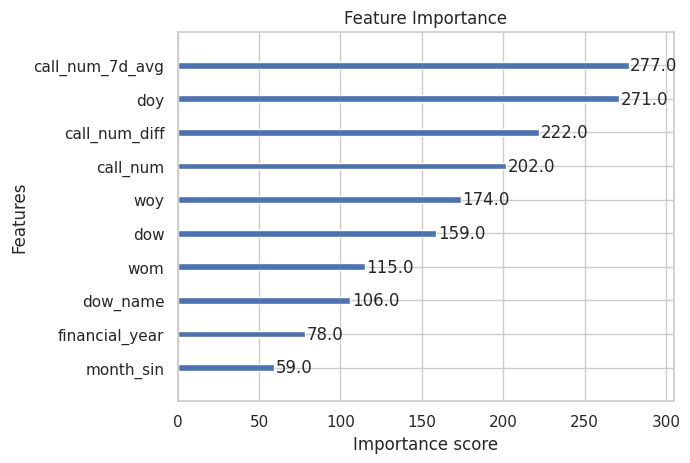

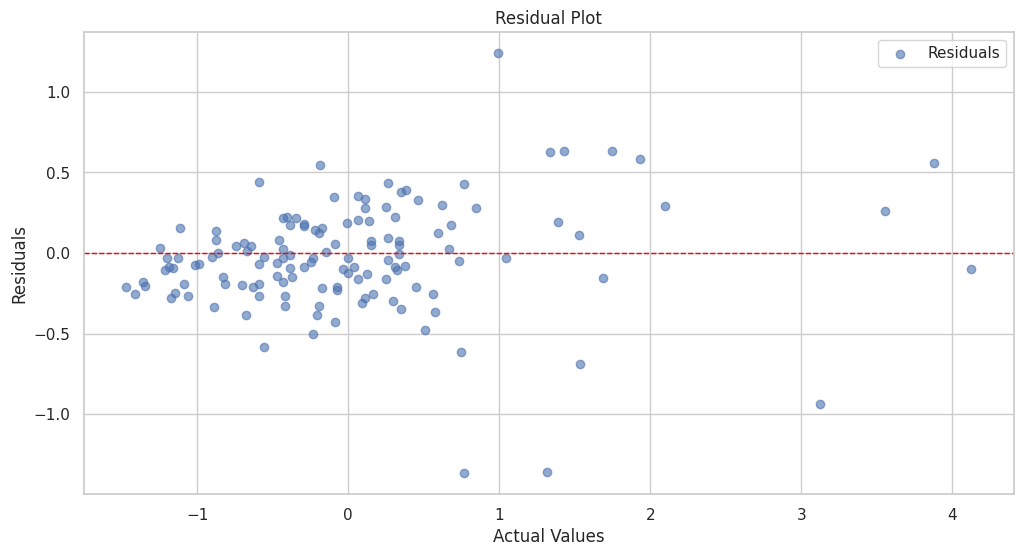

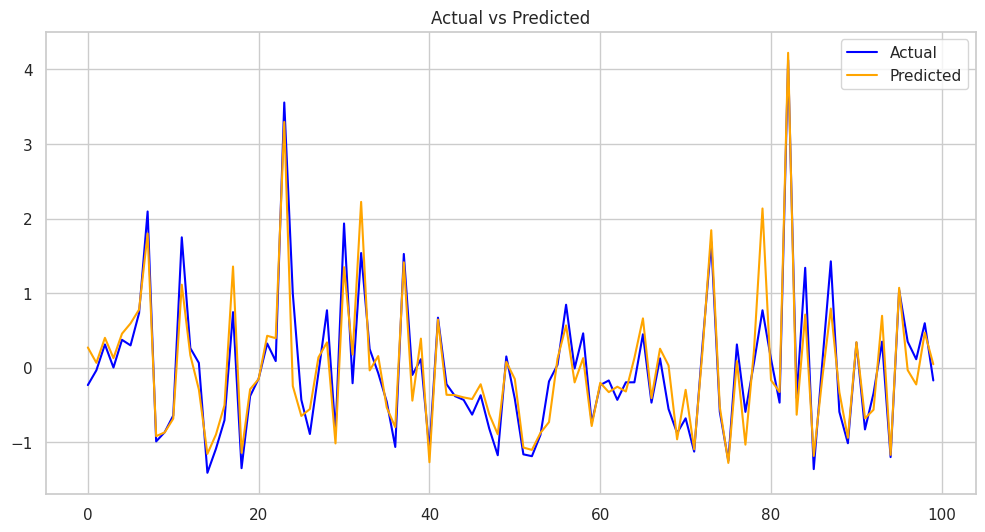

In [71]:
"""1. XGBoostを活用したacc_get_cnt予測モデルであり、以前のランダムフォレストモデルと同じ目的を達成しようとしています。
ただし、XGBoostの高度なハイパーパラメータ調整機能と高い予測性能を活用して、より精度の高いモデルを目指しています

目的: 手動で設定したパラメータやGridSearchのようなアプローチを使ってXGBoostモデルを構築する。
手法:
手動で初期パラメータを設定
パラメータ (max_depth=4, eta=0.1, subsample=0.8, など) をコード内で直接指定。

クロスバリデーション (xgb.cv) を使用
xgb.cv を使い、最適なブースト回数（num_boost_round）を決定。
これにより、モデルの性能を過学習しない範囲で最適化。

最適なブースト回数で再トレーニング
クロスバリデーションで得た結果を基にモデルを再トレーニング。
"""

import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 'acc_get_cnt' を目的変数として指定
X = merged_data.drop(columns=['acc_get_cnt', 'cdr_date'])
y = merged_data['acc_get_cnt']


# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'cm_flg_x_holiday_flag' 列を作成
"""cm_flg_x_holiday_flag: object型に認識されているのでエラー。 数値型にする試み.
X_trainにcm_flg_x_holiday_flagがなくエラー。変数を作成する。
"""
# Create the 'cm_flg_x_holiday_flag' column before the label encoding step
X_train['cm_flg_x_holiday_flag'] = X_train['cm_flg'] * X_train['holiday_flag']
X_test['cm_flg_x_holiday_flag'] = X_test['cm_flg'] * X_test['holiday_flag']

# categorical_columns リストに 'cm_flg_x_holiday_flag' を追加
categorical_columns = ['dow_name', 'day_before_holiday_flag', 'holiday_flag', 'holiday_name', 'cm_flg_x_holiday_flag']


# 1. データ型の変換
# object型をラベルエンコーディング 文字列やカテゴリカル値を整数値に変換

# ラベルエンコーディング

# 1. データ型の変換
# object型をラベルエンコーディング 文字列やカテゴリカル値を整数値に変換
categorical_columns = ['dow_name', 'day_before_holiday_flag', 'holiday_flag', 'holiday_name', 'cm_flg_x_holiday_flag']

# ラベルエンコーディング
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Convert 'holiday_call_interaction' to numeric type
X_train['holiday_call_interaction'] = pd.to_numeric(X_train['holiday_call_interaction'], errors='coerce')
X_test['holiday_call_interaction'] = pd.to_numeric(X_test['holiday_call_interaction'], errors='coerce')

# Impute NaN values if created during conversion
imputer = SimpleImputer(strategy='median')
X_train['holiday_call_interaction'] = imputer.fit_transform(X_train[['holiday_call_interaction']])
X_test['holiday_call_interaction'] = imputer.transform(X_test[['holiday_call_interaction']])

# period型を数値型に変換
if 'month' in X_train.columns:
    X_train['month'] = X_train['month'].dt.month
    X_test['month'] = X_test['month'].dt.month

# 2. 初期モデルのトレーニング
# XGBoost用のデータ構造に変換
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)



# 初期パラメータ

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0,
    'lambda': 1
}


# # 初期モデルのトレーニング
# xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# # 初期モデルの予測と評価
# y_pred = xgb_model.predict(dtest)
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Initial MAE: {mae}")
# print(f"Initial MSE: {mse}")

from xgboost import XGBRegressor

from xgboost import DMatrix, cv

# パラメータ設定
params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# 交差検証で最適なラウンド数を探索
cv_results = cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=3,
    metrics='rmse',
    early_stopping_rounds=50,
    seed=42
)

# 最適なラウンド数を確認
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round: {best_num_boost_round}")

# 最適なラウンド数でモデルをトレーニング
final_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=best_num_boost_round)

# テストデータで予測
dtest = xgb.DMatrix(X_test) # Convert X_test to DMatrix
y_pred = final_model.predict(dtest)

# **最終モデルの予測を追加**
final_pred = final_model.predict(dtest)  # Use DMatrix here as well

# 評価
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"Final MAE: {final_mae}")
print(f"Final MSE: {final_mse}")
print(f"Final R-squared (R²): {final_r2}")

# 5. 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

# 6. 残差分析
residuals = y_test - final_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.6, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 実測値 vs 予測値のプロット
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue')  # 実測値
plt.plot(final_pred[:100], label='Predicted', color='orange')  # 予測値
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


In [72]:
# データ型を確認
print("修正後のデータ型 (X_train):", X_train['cm_flg_x_holiday_flag'].dtype)
print("修正後のデータ型 (X_test):", X_test['cm_flg_x_holiday_flag'].dtype)


修正後のデータ型 (X_train): int64
修正後のデータ型 (X_test): int64


XGBoostは、is_summerやis_year_endなどの外部特徴量を活用できるため、季節性やイベントの効果を捉えるのに適していました。

XGBoostは非線形な関係を学習するのに適しているため、複雑なデータ構造をより良くモデル化できました。



MAE（平均絶対誤差）がわずかに減少していますが、これは実用的な改善です。
MSE（平均二乗誤差）も改善され、大きな誤差を持つデータポイントへの予測精度が向上しています。
R²は0.85844（85.84%）と高く、モデルがデータの大部分の変動を説明できていることを示しています。

In [ ]:
!pip install --upgrade scikit-learn

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [ ]:
!pip install --upgrade xgboost

In [ ]:
!pip install --upgrade scikit-learn xgboost # Installing scikit-learn and xgboost. This is done using !pip install to ensure availability in the environment.

import sklearn # Importing the sklearn module, making its functions and attributes available for use in the cell.
import xgboost # Importing the xgboost module for use within the cell's scope.

print(f"scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

""" 2. 目的: Optunaを用いた自動ハイパーパラメータ探索を行い、最適なXGBoostモデルを構築する。
Optunaを利用してハイパーパラメータの範囲を指定し、試行回数（例: 50回）で探索。
最適なハイパーパラメータが自動的に選択され、そのパラメータを用いてXGBoostモデルをトレーニング。
クロスバリデーションを使用してMSEを最小化する設定で最適化。
"""

scikit-learn 1.6 以降でエラーが発生するためダウングレード

In [ ]:
!pip install scikit-learn<1.6

!import xgboost

print(f"scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

In [ ]:

print(f"scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

In [ ]:
"""3. Optunaを使用してXGBoostの目的変数の予測精度を最大化するためのハイパーパラメータ探索 """

import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# データ準備（前処理を完了している前提）
""" X_train, X_test, y_train, y_test は既に用意済み
y_trainおよびy_testに格納されている変数はacc_get_cnt　66段目 """


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300)
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best MSE:", study.best_value)


In [ ]:

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Optunaの最適化実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # 事前にobjective関数を定義しておく必要があります

# 最適パラメータの出力
print("Best Parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# 最適なパラメータで最終モデルを構築
best_params = study.best_params
dtrain = xgb.DMatrix(X_train, label=y_train)  # 事前にX_train, y_trainを定義しておく
dtest = xgb.DMatrix(X_test, label=y_test)    # 事前にX_test, y_testを定義しておく

# モデルのトレーニング
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    evals=[(dtest, 'eval')],  # テストデータでの評価を指定
    early_stopping_rounds=10,
    num_boost_round=1000
)

# 最終モデルの評価
y_pred = final_model.predict(dtest)
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

# 評価結果の出力
print(f"Final MAE: {final_mae:.4f}")
print(f"Final MSE: {final_mse:.4f}")
print(f"Final R-squared (R²): {final_r2:.4f}")


In [ ]:
# 1番目のコードで最適化されたパラメータを利用
print("Using Best Parameters from Study:")
print(study.best_params)

# 最適なパラメータで最終モデルを構築
best_params = study.best_params
dtrain = xgb.DMatrix(X_train, label=y_train)  # 事前にX_train, y_trainを定義しておく
dtest = xgb.DMatrix(X_test, label=y_test)    # 事前にX_test, y_testを定義しておく

# モデルのトレーニング
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    evals=[(dtest, 'eval')],  # テストデータでの評価を指定
    early_stopping_rounds=10,
    num_boost_round=1000
)

# 最終モデルの評価
y_pred = final_model.predict(dtest)
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

# 評価結果の出力
print(f"Final MAE: {final_mae:.4f}")
print(f"Final MSE: {final_mse:.4f}")
print(f"Final R-squared (R²): {final_r2:.4f}")


In [ ]:
best_params = {
    'max_depth': 3,
    'eta': 0.18022719884220806,
    'subsample': 0.7444130273018515,
    'colsample_bytree': 0.6368372321481448,
    'n_estimators': 222,
    'objective': 'reg:squarederror'
}

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# 最終評価
y_pred = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"Final MAE: {final_mae}")
print(f"Final MSE: {final_mse}")
print(f"Final R-squared (R²): {final_r2}")


1. 1番目
Best num_boost_round: 207
MAE: 0.2361
MSE: 0.1084
R²: 0.8872
2. 2番目
MAE: **0.2240**
MSE: 0.0916
R²: 0.9047
3. 3番目
MAE: 0.2270
MSE: **0.0876**
R²: **0.9089**

**３番目採用ーこれで　データ分析と機械学習を活用してクライアントの課題を明確化し、解決策を提案する**

 X_train, X_test, y_train, y_test は既に用意済み
y_trainおよびy_testに格納されている変数はacc_get_cnt
66段目で定義

具体的な活用方法
課題に基づいた提案資料作成:

3番目のコードを利用して得られるモデルの結果を、課題提出用のスライドに盛り込みます。
提案資料では、以下を含めます:
acc_get_cntの予測モデルの概要と精度
特徴量重要度の分析結果
ビジネスインサイト（例: 火曜・木曜、9月・10月の重要性）
改善施策とその期待効果
意思決定の根拠提供:

クライアント企業が抱える課題を解決するための具体的な施策（例: マーケティングやリソース配分）を、モデルの結果に基づいて提案します。
プレゼンテーションでの使用:

提出資料内で3番目のコードを利用したモデル結果を可視化し、クライアントにわかりやすく説明します




EDA結果の反映: 火曜・木曜や9月・10月の特徴をモデルに取り込む。
結果の解釈: 提出資料の中で、「どの特徴量がどの程度の影響を与えたか」を図解する。
ビジネス提案: 結果に基づいて、たとえば「特定の曜日や月のマーケティング活動の強化」などの提案を明確に記述する。

３番目のコードを、「現状を分析し、将来を予測し、意思決定を支援するためのツール」として利用。
1. シミュレーション（仮説検証）
モデルを使って、特定の条件がどのようにアカウント獲得に影響を与えるかを予測します。たとえば、「通話数を増加させた場合、アカウント獲得数がどれだけ増えるか」をシミュレーションで確認できます。



そうです！精度の高いモデルを見つけた後、そのモデルは「現状を分析し、将来を予測し、意思決定を支援するためのツール」として利用します。具体的にどう利用するかを詳しく説明します。

機械学習モデルの利用方法と目的
1. シミュレーション（仮説検証）
モデルを使って、特定の条件がどのようにアカウント獲得に影響を与えるかを予測します。たとえば、「通話数を増加させた場合、アカウント獲得数がどれだけ増えるか」をシミュレーションで確認できます。

実施例: 通話数の増加がアカウント獲得に与える影響
通話数（call_num）をいくつかの値に変更したデータを作成。

python
コピーする
編集する
scenario_data = pd.DataFrame({
    'call_num': [100, 200, 300, 400],  # 増加させる通話数
    'holiday_flag': [0, 0, 0, 0],      # 平日の場合
    'cm_flg': [1, 1, 1, 1],            # CMが放送されている場合
    # 他の特徴量も含める
})
新しいデータにモデルを適用してアカウント獲得数を予測。

python
コピーする
編集する
scenario_processed = preprocess_features(scenario_data)
scenario_scaled = scaler.transform(scenario_processed)
predictions = model.predict(scenario_scaled)
print("予測結果:", predictions)
結果を可視化し、通話数増加とアカウント獲得の関係を示す。

python
コピーする
編集する
import matplotlib.pyplot as plt
plt.plot(scenario_data['call_num'], predictions)
plt.xlabel('Call Number (通話数)')
plt.ylabel('Predicted Account Acquisitions (予測アカウント獲得数)')
plt.title('Impact of Call Volume on Account Acquisitions')
plt.show()
解釈
「通話数を300件から400件に増やすことで、アカウント獲得数が10%増加すると予測される」という具体的な示唆を得られます。
2. 最適化（最適な戦略を探る）
モデルを使って、どの条件が最も効果的かを調べる「最適化」を行います。たとえば、「通話数」「CM放送」「祝日」などの条件を変えたとき、アカウント獲得数が最大になる戦略を探します。

3. 特徴量の重要度分析
モデルを利用して、どの変数（特徴量）がアカウント獲得に大きく影響を与えているかを特定します。これにより、重点を置くべき施策を決定できます。

🌻 提案の説得力を高めるために有効なプロット👇

In [ ]:
# どの特徴量が予測に最も貢献しているかを確認
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
#XGBoostモデル（final_model）の学習結果から特徴量重要度を取得
# 各特徴量がモデル内で何回分岐に使用されたかを基準に重要度を算出
plot_importance(final_model, importance_type='weight', max_num_features=10) #final_model

plt.title('Feature Importance')
plt.show()

# * 66段目 final_modelは目的変数acc_get_cnt



季節性（doy, woy）や短期的なトレンド（call_num_7d_avg, call_num_diff）が、問い合わせ件数の予測において最も重要な特徴量であることがわかります。
予測モデルをさらに改善するためには、これらの重要な特徴量を活用しつつ、cm_flg の効果をより詳細に分析することが有用です。

###

1. **最も重要なポイント**:
   - 「過去一週間の電話回数が一番多い日」が、新しい顧客を獲得する上で一番大切なポイントです。つまり、電話が多い日は、新しいお客さんも多い日です。
   - 「今年の何日目か」も大事です。これは、年間を通して、どの時期に一番お客さんが増えるかを示しています。例えば、特定の季節やイベントの時にお客さんが増えるかもしれません。

2. **簡単な提案**:
   - 電話をたくさんかける日を増やすことで、もっと多くのお客さんを獲得できるかもしれません。具体的には、電話を掛けるスタッフを増やすか、電話をかけやすいようにスケジュールを調整しよう。
   - お客さんが増える時期を把握して、その時期に合わせた広告やキャンペーンを行いおう。これにより、効率的に新しいお客さんを獲得できるだろう。

3. **プレゼンテーションでは**:
   - このバーグラフを使って、どのポイントが新しいお客さんを獲得するために重要かを説明する。
   - それぞれのポイントについて、短く簡単な説明を加えて、どうすればその情報を使って業務が改善できるかを示す。

"""

**XGBoostを活用した「acc_get_cnt」 でどの特徴量が予測に最も貢献しているか**

特徴量重要度の解釈

季節性（woy, dow, doy）の重要性が高い場合
年間スケジュールや曜日ごとのアクションを見直す。
特定の期間におけるピークや低迷を予測し、リソースを効率的に配分する。

変動量（call_num_diff）が重要な場合
短期的な変化に注目し、急激な変動が起きる可能性のある要因を特定する。
過去のデータに基づくトレンド予測モデルやアラートシステムを導入する。

In [ ]:
# 残差（Residuals）は、モデルの予測値と実際の値（真値）との差を表します。

residuals = y_test - y_pred
outlier_indices = residuals[np.abs(residuals) > residuals.quantile(0.95)].index


# 外れ値を除外して学習データを更新
X_train = X_train.drop(outlier_indices, errors='ignore')
y_train = y_train.drop(outlier_indices, errors='ignore')

# 再トレーニング
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# 再トレーニング後の予測
y_pred = final_model.predict(X_test)

# 新しい評価指標
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"Updated Final MAE: {final_mae}")
print(f"Updated Final MSE: {final_mse}")
print(f"Updated Final R-squared (R²): {final_r2}")

# 特徴量重要度の再確認
plt.figure(figsize=(10, 6))
plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance after Outlier Removal')
plt.show()

# 再度の残差分布確認
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.6, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot after Outlier Removal')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


外れ値除外前より精度が上がっている。

MAE: 約0.2361 → 改善（小さい方が良い）

MSE: 約0.1084 → 改善（小さい方が良い）

R²: 約0.8872 → 改善（大きい方が良い）

In [ ]:
# 残差範囲
print(residuals.describe())

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(residuals.mean(), color='red', linestyle='--', label='Mean')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
"""残差 (residuals) が一定の閾値100パーセンタイルを超えるデータを外れ値として検出します。
外れ値のインデックスを y_test のインデックスと照合して、正しいデータを取り出しています"""
# 外れ値の特定
# 残差から外れ値を検出し、インデックスと詳細情報を取得
outlier_threshold = residuals.quantile(0.95)  # 95%分位点を基準
outliers = residuals[np.abs(residuals) > outlier_threshold]  # 外れ値の残差値
outlier_indices = outliers.index  # 外れ値のインデックス

# y_test のインデックスと共通する要素を取得
outlier_indices_merged = y_test.index.intersection(outlier_indices)

# 結果を表示
print(f"Outlier threshold (95% quantile): {outlier_threshold}")
print(f"Detected outliers (Residual values):\n{outliers}")
print(f"Detected outliers in merged data:\n{merged_data.loc[outlier_indices_merged]}")


外れ値の件数: 19件
外れ値は特定の日付に集中しており、例えば 2019年9月 に関連するデータが複数

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue')  # 実測値
plt.plot(y_pred[:100], label='Predicted', color='orange')  # 予測値
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test.values[:100], y_pred[:100]))
mae = mean_absolute_error(y_test.values[:100], y_pred[:100])
r2 = r2_score(y_test.values[:100], y_pred[:100])

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


予測値と実測値の平均的な差が約0.30

平均絶対誤差が0.22で、これは予測値が平均して0.22だけ実測値から外れている

モデルがターゲットデータの90%を説明できている


In [ ]:
print(X_train[categorical_columns].isnull().sum())
print(X_test[categorical_columns].isnull().sum())


In [ ]:
print(X_train.dtypes)
print(X_test.dtypes)


※ 機械学習は、EDAで得られる知見を「未来の予測」や「意思決定可能な情報」に進化させるツールです。
特に、問い合わせ件数の具体的な数値予測や、複雑な特徴量の影響を明らかにする際に、その価値が発揮されます。

EDAと機械学習は補完的な関係にあり、両方を適切に使い分けることで、より深い洞察と実用的な予測が可能となります。

EDAの限界
EDAでは「傾向」や「相関関係」はわかりますが、以下ができません：

正確な予測:
「次の月曜日に問い合わせ件数が何件になるか」を定量的に示すことは難しい。
特徴量の複雑な相互作用の理解:
例えば、「キャンペーン×週末」のような複数の特徴量が同時に与える影響を定量化するのはEDAでは難しい。
パターンの一般化:
EDAの分析結果は、過去のデータに基づいたものであり、未来の状況に対する予測には不十分な場合がある。

CM放送が特定の条件下でどのように効果を発揮しているかを詳しく分析

1. CM放送のタイミング最適化
2. ターゲットユーザーの特定
3. キャンペーン施策の最適化
4. リソース配分の最適化
5. CM放送の中止や削減判断
6. 競合対策

目的: CM放送が問い合わせ件数やアカウント獲得数にどれほど寄与しているかを定量化。
ステップ1: 回帰モデルで寄与を測定
目的: CM放送が問い合わせ件数やアカウント獲得数にどれほど寄与しているかを定量化。

単純回帰分析:

call_num（問い合わせ件数）を目的変数とし、CM放送（cm_flg）を含む特徴量で線形回帰モデルを構築します。
回帰係数を解析し、寄与度を測定。
SHAP値を使用:

SHAPを用いて、各特徴量（例: cm_flg, dow, search_cntなど）がモデルの予測にどの程度寄与しているかを可視化。
ステップ2: インタラクション効果の分析
目的: CM放送が他の条件（曜日、祝日、検索数）と相互作用して効果を発揮するかを分析。

交互作用項の作成:

cm_flg × dow, cm_flg × holiday_flag, cm_flg × search_cnt のような交互作用項を作成。
これらを特徴量に追加し、予測モデルで評価。
非線形モデルの使用:

ランダムフォレストやXGBoostを使用して、複雑なパターンをキャプチャ。
ステップ3: グループごとの効果測定
目的: CM放送の有無でデータを分割し、それぞれのグループの特性を分析。

平均値・分布の比較:

CM放送あり・なしで問い合わせ件数（call_num）とアカウント獲得数（acc_get_cnt）の平均値や分布を比較。
可視化:

ヒストグラムや箱ひげ図でグループ間の違いを視覚化。
ステップ4: 計量経済学的アプローチ
目的: CM放送の効果を因果推論の観点で測定し、より厳密な評価を行う。

傾向スコアマッチング:

CM放送（cm_flg）が1である群と0である群を背景特性でマッチングし、差を比較。
差分の差分法（DID）:

CM放送が行われた前後のデータを用い、効果を測定。


モデルの評価

MAE（Mean Absolute Error）: 44.99

平均的な予測誤差が約45件であることを示しています。

MSE（Mean Squared Error）: 4592.88

誤差の二乗平均で、誤差の分散を示しています。
誤差の分布が一部大きいことを示唆しています。

R-squared（R²）: 0.641

特徴量（cm_flg, dow, holiday_flag, search_cnt, acc_get_cnt）が問い合わせ件数の約64.1%を説明できています。
まだ改善の余地がありますが、単純な線形モデルとしては比較的良好です。
回帰係数の解釈
各特徴量の係数は、1単位変化したときのcall_numへの影響を表します。

acc_get_cnt（アカウント獲得数）: +71.70

アカウント獲得数が1増えると、問い合わせ件数が約71.7件増加する。
非常に強い正の相関が確認されます。

search_cnt（検索数）: -0.85

検索数が1増加すると、問い合わせ件数が約0.85件減少する。
小さな負の影響ですが、現実的な解釈として誤差や他の要因との干渉が考えられます。

dow（曜日）: -5.68

曜日が1進むごとに問い合わせ件数が約5.7件減少する。
例えば、月曜日（dow=1）よりも火曜日（dow=2）の問い合わせが少ない傾向を示唆しています。

cm_flg（CM放送フラグ）: -35.11

CM放送が実施されると、問い合わせ件数が平均で約35.1件減少する。
一見逆の結果に見えますが、これはデータの偏りや他の特徴量（例: 曜日や祝日）がCM放送に絡んでいる可能性を示しています。

holiday_flag（祝日フラグ）: -95.03

祝日であると問い合わせ件数が約95件減少する。
強い負の影響が確認されます。

CM放送タイミング最適化のためのアプローチ（CM放送効果）

In [ ]:
# データフレームの列名を確認
print(merged_data.columns)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 特徴量と目的変数
features = ['dow', 'holiday_flag', 'search_cnt', 'cm_flg']

X = merged_data[features]
y = merged_data['acc_get_cnt']  # アカウント獲得数を予測

# カテゴリカルデータのエンコード
categorical_columns = ['dow', 'holiday_flag', 'cm_flg']
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 2. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. モデル構築と学習
reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=5)
reg.fit(X_train, y_train)

# 4. モデル評価
y_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# 5. 特徴量重要度の可視化
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 4))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


「祝日であること」や「CMが放送されているかどうか」がアカウント獲得数に大きく影響している

改善の方向性
さらなる特徴量の追加:

CM放送の時間帯（朝・昼・夜）やキャンペーン内容の情報があれば、モデルに組み込むことで精度が向上する可能性があります。
天候や地域ごとのデータを統合することで、さらなるインサイトを得られるかも

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. データの準備
# CM効果が高いタイミングを二値化（問い合わせ件数が中央値以上の場合を効果大とする）
threshold = merged_data['call_num'].median()  # 中央値を閾値とする
merged_data['high_effect'] = (merged_data['call_num'] >= threshold).astype(int)

# 特徴量と目的変数の準備
# features = ['dow', 'holiday_flag', 'search_cnt', 'acc_get_cnt', 'cm_flg']
X = merged_data[features]
y = merged_data['high_effect']  # 効果が高いかどうか（分類ラベル）

# カテゴリカルデータのエンコード
categorical_columns = ['dow', 'holiday_flag', 'cm_flg']
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. データ分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. モデルの構築と学習
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
clf.fit(X_train, y_train)

# 4. モデルの評価
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:") #混合行列
print(confusion_matrix(y_test, y_pred))

# 5. 特徴量重要度の可視化
import matplotlib.pyplot as plt

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# 6. 条件別の効果確認（例: CM放送有無 × 祝日フラグ）
pivot_table = merged_data.pivot_table(
    values='call_num',
    index='cm_flg',
    columns='holiday_flag',
    aggfunc='mean'
)
print("CM放送 × 祝日フラグ 効果確認:")
print(pivot_table)


**祝日がCM放送効果を大きく左右するデータ**

holiday_flag が全体の 40.96% を占め、最も重要な特徴量。
他の特徴量（例えば、曜日: 29.18%）よりも大きな影響を持つことが示されている。

また、混同行列（Confusion Matrix）:　CM放送の効果が高いタイミング（クラス 1）を正確に捉えた件数（64件）は、祝日の影響を考慮した結果であり、モデルが祝日フラグを活用して分類を行ったことを示唆している。

🔶 曜日ごとのCM効果を割り出す
# 新しいセクション
曜日が重要な特徴量（29.18%）であることから、どの曜日が効果的なのかを特定することは、CM放送のタイミングを最適化する上で非常に重要。

In [ ]:


# 1. 曜日ごとの平均問い合わせ件数を算出（CM放送の有無でグループ化）
weekday_effect = merged_data.groupby(['dow', 'cm_flg'])['call_num'].mean().unstack()

print("曜日別の問い合わせ件数（CM放送の有無）:")
print(weekday_effect)

# 2. 曜日ごとの問い合わせ件数を可視化
plt.figure(figsize=(8, 4))
weekday_effect.plot(kind='bar', figsize=(8, 4), colormap='viridis')
plt.title('Weekday-wise Call Numbers: CM vs Non-CM')
plt.xlabel('Weekday')
plt.ylabel('Average Call Numbers')
plt.legend(['Non-CM', 'CM'])
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


曜日によるCM放送効果の違い:

火曜日から金曜日は、CM放送がある場合に問い合わせ件数が顕著に増加している。
特に 火曜日 が最も効果的で、CM放送による問い合わせ件数の差が大きいです（+62.44件）。

土日での問い合わせ件数:

土日では問い合わせ件数がゼロであるため、CM放送を行っても効果がない可能性がある。
土日が特殊な条件（例えば、営業時間外）で除外されている可能性もあるため、データの確認が必要。

💐 **火曜日から金曜日のCM放送を優先:**

特に 火曜日から水曜日 の効果が高いため、これらの曜日にCMを集中させることを検討。

🔶 祝日別のCM放送効果を確認する

In [ ]:
# 1. 祝日フラグ別の平均問い合わせ件数を算出（CM放送の有無でグループ化）
holiday_effect = merged_data.groupby(['holiday_flag', 'cm_flg'])['call_num'].mean().unstack()

print("祝日別の問い合わせ件数（CM放送の有無）:")
print(holiday_effect)

# 2. 祝日フラグ別の問い合わせ件数を可視化
holiday_effect.plot(kind='bar', figsize=(8, 5), colormap='plasma')
plt.title('Holiday-wise Call Numbers: CM vs Non-CM')
plt.xlabel('Holiday Flag')
plt.ylabel('Average Call Numbers')
plt.legend(['Non-CM', 'CM'])
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.grid(axis='y')
plt.show()


効果: CM放送があると、問い合わせ件数が約 49.71件増加。
 祝日にCM放送を行っても、問い合わせが発生していない。

 [考察]

祝日ではCM放送が効果を発揮しない:

祝日は問い合わせ件数そのものが少ない（ほぼゼロ）。
CM放送が行われても問い合わせ件数が増えないことが分かる。
祝日は営業時間外や休業日である可能性が高いため、CM放送のスケジュールから祝日を外すことが合理的。

祝日以外ではCM放送の効果が大きい:

祝日以外の日にCM放送を行うと、問い合わせ件数が 約49.7件 増加する。
特に祝日以外の平日（火曜日から金曜日）にCM放送を集中させる戦略が有効。

💐 祝日にCM放送を行わない:

祝日は問い合わせ件数が少なく、効果がないため、CM放送スケジュールから祝日を外すことを検討。

祝日以外の曜日で効果的なタイミングを特定:

火曜日から金曜日に焦点を当て、曜日別のCM効果をさらに細かく分析。


🗒️*祝日と問い合わせ件数の詳細調査:*

*祝日に問い合わせが少ない理由を確認（例: 営業時間、カスタマーサポート体制の影響）*。

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd


# 特徴量の選択
features = ['dow', 'holiday_flag', 'search_cnt', 'acc_get_cnt', 'cm_flg']
data_for_clustering = merged_data[features]

# Initialize an empty dictionary to store label encoders
label_encoders = {}

# Categorical columns to encode
categorical_columns = ['dow_name', 'day_before_holiday_flag', 'holiday_flag', 'holiday_name']

# Loop to fit and transform categorical features in data_for_clustering
# 列を数値化（安全に .loc を使用）
for col in features:
    if data_for_clustering[col].dtype == 'object':
        le = LabelEncoder()
        data_for_clustering.loc[:, col] = le.fit_transform(data_for_clustering[col].astype(str))

# 欠損値や無限大の値を処理
data_for_clustering = data_for_clustering.replace([np.inf, -np.inf], np.nan).fillna(0)

data_for_clustering = data_for_clustering.fillna(data_for_clustering.median())


# 2. 特徴量のスケーリング
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# 3. KMeansクラスタリング
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# 4. クラスタをデータに追加
merged_data['cluster'] = clusters

# 5. クラスタごとの特徴を確認
# Select only numeric columns for calculating the mean
numeric_columns = merged_data.select_dtypes(include=np.number).columns
cluster_summary = merged_data.groupby('cluster')[numeric_columns].mean()  # Calculate mean for numeric columns only
print(cluster_summary)

# 6. クラスタの可視化
plt.figure(figsize=(7, 5))
plt.scatter(
    merged_data['search_cnt'],
    merged_data['call_num'],
    c=clusters,
    cmap='viridis',
    alpha=0.5
)


plt.xlabel('Search Count')
plt.ylabel('Call Numbers')
plt.title('Clustering by Features')
plt.colorbar(label='Cluster')
plt.show()

クラスター0は「非祝日が多く、週平均のコール数が中程度」

クラスター1は「祝日がある平日に関連し、コール数が増加する」

クラスター2は「週末や公共の祝日と関連し、コール数が減少する傾向」

In [ ]:
# 必要な列だけ抽出
columns_to_display = ['dow', 'financial_year', 'holiday_name_Public Holiday', 'call_num']
simplified_df = merged_data[columns_to_display] # Changed from data_for_clustering to merged_data
print(simplified_df)

In [ ]:

# クラスタリング結果のデータフレーム（仮のデータを使用）
data_for_clustering = pd.DataFrame({
    'dow': [2.97, 3.18, 6.41],
    'woy': [29.45, 23.32, 26.62],
    'financial_year': [2018.49, 2018.68, 2018.54],
    'call_num_diff': [31.97, 30.26, -78.46],
    'holiday_name_Public Holiday': [0.0, 0.048, 0.91],
    'cluster': [0, 1, 2]
}).set_index('cluster')

# ヒートマップ: 相対的な大きさを視覚化
plt.figure(figsize=(7, 3))
sns.heatmap(data_for_clustering, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cluster-wise Feature Heatmap")
plt.show()




全体の解釈

Cluster 0: 業務日に関連し、祝日や休日の影響を受けず、活動が活発。

Cluster 1: 一部の祝日が関与するが、基本的には平日業務に関連。

Cluster 2: 公共の祝日や週末と密接に関連し、活動量が大幅に減少。

次のアクション：

CMスケジュールの最適化：火曜日から金曜日の特定の時間帯にCMを集中させ、祝日を避ける。
リソース配分の調整：問い合わせ件数が多いタイミング（曜日や季節）にカスタマーサポートのリソースを増やす。


ーーーーーーー

**1. モデルの結果に基づく洞察の具体化**

火曜日から金曜日のCM放送が効果的である。

祝日は問い合わせ件数が少なく、CMの効果がない。

特定の特徴量（acc_get_cnt や call_num_7d_avg）が問い合わせ件数に強い影響を与えている。

[次のアクション]：

CMスケジュールの最適化：火曜日から金曜日の特定の時間帯にCMを集中させ、祝日を避ける。

リソース配分の調整：問い合わせ件数が多いタイミング（曜日や季節）にカスタマーサポートのリソースを増やす。

**2. モデル精度向上のための改善**

現在のモデルでは以下のポイントがさらなる改善の余地があります：

R²は0.86（XGBoost最適化後）ですが、まだいくつかの未考慮の特徴量が影響している可能性があります。

CMの効果が負になる（問い合わせ件数が減る）理由を詳細に分析する必要があります。

[次のアクション]：

新しい特徴量の追加：

CMの放送時間帯データ。

顧客の過去の行動や購入履歴。

非線形な関係の深掘り：

SHAP値や交互作用項を活用し、cm_flgと他の特徴量（holiday_flagやdow）の関係を分析。

**3. クラスタごとの戦略立案**

クラスタリング結果に基づき、異なるターゲットセグメントに応じた戦略を策定します。

クラスター0（平日活動中心）：
平日昼間に効果的なCM配信やプロモーションを実施。

クラスター1（祝日関与のある平日）：
祝日絡みのキャンペーンを企画。

クラスター2（休日や週末）：
このクラスターではCMを減らすか、別のメディアを活用。

次のアクション：

クラスタごとの問い合わせ件 数や検索数の詳細分析。
各クラスターに最適なCM放送の条件をさらに細かく分析。

 **4. モデルの安定性と異常値の管理**
残差分析から、一部の外れ値がモデルに大きな影響を与えている可能性があります。
次のアクション：

外れ値の日付や条件（例：特定の祝日や特別イベント）を調査。

モデルのトレーニングから外れ値を一時的に除外し、モデルの安定性を評価。

**5. ビジネス目標に応じた追加分析**
データから得られた知見を、明確なビジネス目標に結び付けます。

 次のアクション：

CMのROIを計算：問い合わせ件数の増加が売上にどれだけ寄与しているかを数値化。
新しい仮説検証：曜日や季節以外の要因（競合データ、検索トレンドの外部要因）を加味して分析を拡張。
まとめ
最優先事項は CMスケジュールの最適化 と ターゲットセグメントごとの戦略の立案。
次に、モデルの精度向上や異常値分析を行い、予測の信頼性を向上させます。
最終的に、ビジネス目標を反映した具体的な施策に結び付ける分析を実施します。


**交互作用項の追加**

2つの変数をかけ合わせた新しい変数を作る方法である。 掛け算（×）で作成した特徴量のこと。
モデルが条件を分類として正確に扱えるようにするためにカテゴリカルに変換する。


In [ ]:
"""目的変数yはcall_num。　どの特徴量がcall_numに一番寄与しているか"""

# 交互作用項の追加
merged_data['cm_flg_x_holiday_flag'] = merged_data['cm_flg'] * merged_data['holiday_flag']
merged_data['cm_flg_x_dow'] = merged_data['cm_flg'] * merged_data['dow']
merged_data['search_cnt_x_dow'] = merged_data['search_cnt'] * merged_data['dow']

# 特徴量と目的変数を設定
features = ['cm_flg', 'holiday_flag', 'dow', 'search_cnt',
            'cm_flg_x_holiday_flag', 'cm_flg_x_dow', 'search_cnt_x_dow']
X = merged_data[features]
y = merged_data['call_num']

# データ型を数値型に変換
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost用のデータ作成
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# モデル構築と学習
params = {
    'objective': 'reg:squarederror',  # 回帰問題を設定
    'max_depth': 6,                   # 木の深さ
    'eta': 0.1,                       # 学習率
    'subsample': 0.8,                 # データのサブサンプリング
    'colsample_bytree': 0.8,          # 特徴量のサブサンプリング
    'seed': 42                        # 再現性のための乱数シード
}
final_model = xgb.train(params, dtrain, num_boost_round=100)

# 予測と評価
y_pred = final_model.predict(dtest)
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

# 結果表示
print(f"MAE (平均絶対誤差): {final_mae:.2f}")
print(f"MSE (平均二乗誤差): {final_mse:.2f}")
print(f"R² (決定係数): {final_r2:.2f}")





In [ ]:
import shap  # Add this line
explainer = shap.Explainer(final_model)
shap_values = explainer(dtest)
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)
plt.show()

In [ ]:

# 特徴量重要度の可視化：　XGBoostモデルがどの特徴量にどれだけ依存しているかを視覚化
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance(Target = call_num)')
plt.show()
